# Import Libraries

In [1]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
from scipy.interpolate import interp1d

import random
import xgboost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statsmodels.api as sm
from datetime import datetime, timedelta

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 300)

# Function Declaration

In [2]:
client = bigquery.Client()

def get_data(query):
    return client.query(query).to_dataframe()

# Get Data

In [3]:
akses_internet = get_data("SELECT provinsi, kota, date, value FROM `katadata-sales-planning.katadata_sales_planning.p2_persentase_akses_internet_perJK_kabkota`")
kategori_usia = get_data("SELECT nama, provinsi, kota, date, value FROM `katadata-sales-planning.sandbox_spt.raw_jumlah_penduduk_kategori_usia_kabkota`")
jumlah_penduduk = get_data("SELECT provinsi, kota, date, value FROM `katadata-sales-planning.sandbox_spt.raw_jumlah_penduduk_kabkota`")
jumlah_penduduk_provinsi = get_data("SELECT provinsi, date, value FROM `katadata-sales-planning.sandbox_spt.raw_jumlah_penduduk_provinsi`")
penduduk_laki_laki = get_data("SELECT provinsi, date, value FROM `katadata-sales-planning.sandbox_spt.raw_jumlah_penduduk_laki_laki_provinsi`")
penduduk_perempuan = get_data("SELECT provinsi, date, value FROM `katadata-sales-planning.sandbox_spt.raw_jumlah_penduduk_perempuan_provinsi`")
upah_minimum = get_data("SELECT provinsi, kota, date, value FROM `katadata-sales-planning.sandbox_spt.raw_upah_minimum_kabupaten_kabkota`")
indeks_harga_konsumen = get_data("SELECT provinsi, kota_kab, date, value FROM `katadata-sales-planning.sandbox_spt.bps_indeks_harga_konsumen`")
inflasi = get_data("SELECT * FROM `katadata-sales-planning.sandbox_spt.bps_inflasi_tahunan_90_kota_2020_2022`")
ecommerce_menjual_kosmetik = get_data("SELECT * FROM `katadata-sales-planning.sandbox_spt.bps_percentage_ecommerce_selling_cosmetics`")
jumlah_supermarket = get_data("SELECT year, prov, kota_kab, minimarket_supermarket FROM `katadata-sales-planning.sandbox_spt.raw_data_podes`")
jumlah_industri_kosmetik = get_data("SELECT * FROM `katadata-sales-planning.sandbox_spt.bpom_jumlah_industri_kosmetik_di_indonesia`")
google_trend = get_data("SELECT month, provinsi, kab_kota, keyword, search_volume FROM sandbox_spt.raw_google_trend_data_location")
compas_data = get_data("SELECT province, city, sum(sales_value) AS sum_sales, sum(sales_qty) AS sales_qty, count(distinct seller_name) AS unique_seller FROM `katadata-sales-planning.sandbox_spt.raw_compas_seller_location_distribution_table` WHERE city IS NOT NULL GROUP BY province, city ORDER BY province, city")
pdrb_farmasi = get_data("SELECT provinsi, date, value FROM `katadata-sales-planning.sandbox_spt.raw_pdrb_adhk_industri_kimia_farmasi_dan_obat_tradisional_provinsi`")
pdrb = get_data("SELECT nama, provinsi, kota, date, value FROM `katadata-sales-planning.sandbox_spt.raw_pdrb_adhk_kabkota`")
data_susenas_kecantikan = get_data("SELECT provinsi, kota, date, value FROM `katadata-sales-planning.sandbox_spt.raw_rerata_pengeluaran_perkapita_sebulan_kecantikan_kabkota`")
data_susenas_perawatan = get_data("SELECT provinsi, kota, date, value FROM `katadata-sales-planning.sandbox_spt.raw_rerata_pengeluaran_perkapita_sebulan_perawatan_kabkota`")

In [4]:
# AKSES INTERNET
akses_internet['year'] = pd.DatetimeIndex(akses_internet['date']).year
akses_internet.drop(columns = 'date', inplace = True)
akses_internet.rename(columns = {'kota':'kota_kab', 'value':'akses_internet'}, inplace = True)

# KATEGORI USIA
kategori_usia['year'] = pd.DatetimeIndex(kategori_usia['date']).year
kategori_usia.drop(columns = 'date', inplace = True)
kategori_usia.rename(columns = {'kota':'kota_kab'}, inplace = True)
kategori_usia = kategori_usia.pivot_table(index=['provinsi', 'kota_kab', 'year'], columns='nama', values='value', aggfunc='first').reset_index()
kategori_usia = kategori_usia.rename_axis(None, axis=1)
kategori_usia_num = kategori_usia.columns[~kategori_usia.columns.isin(['provinsi', 'kota_kab'])]
kategori_usia[kategori_usia_num] = kategori_usia[kategori_usia_num].apply(pd.to_numeric, errors='coerce')
kategori_usia['year'] = kategori_usia['year'].astype(float)
kategori_usia.drop(columns = ['Jumlah Penduduk Menurut Kabupaten: Umur 0-4 Tahun', 'Jumlah Penduduk Menurut Kabupaten: Umur 5-9 Tahun', 
                              'Jumlah Penduduk Menurut Kabupaten: Umur 10-14 Tahun', 'Jumlah Penduduk Menurut Kabupaten: Umur 65-69 Tahun', 
                              'Jumlah Penduduk Menurut Kabupaten: Umur 70-74 Tahun', 'Jumlah Penduduk Menurut Kabupaten: Umur Lebih dari 75 Tahun'], inplace = True)
kategori_usia['penduduk_usia_produktif'] = kategori_usia.iloc[:,3:].sum(axis=1)
kategori_usia = kategori_usia.loc[:,['provinsi', 'kota_kab', 'year', 'penduduk_usia_produktif']]
kategori_usia = kategori_usia.replace({0: np.nan})

# JUMLAH PENDUDUK
jumlah_penduduk['year'] = pd.DatetimeIndex(jumlah_penduduk['date']).year
jumlah_penduduk = jumlah_penduduk.sort_values('date').drop_duplicates(['provinsi', 'kota', 'year'], keep = 'last')
jumlah_penduduk.drop(columns = 'date', inplace = True)
jumlah_penduduk.rename(columns = {'kota':'kota_kab', 'value':'jumlah_penduduk'}, inplace = True)
jumlah_penduduk['jumlah_penduduk'] = jumlah_penduduk['jumlah_penduduk'].astype(float)

# JUMLAH PENDUDUK PROVINSI
jumlah_penduduk_provinsi['year'] = pd.DatetimeIndex(jumlah_penduduk_provinsi['date']).year
jumlah_penduduk_provinsi = jumlah_penduduk_provinsi.sort_values('date').drop_duplicates(['provinsi', 'year'], keep = 'last')
jumlah_penduduk_provinsi.drop(columns = 'date', inplace = True)
jumlah_penduduk_provinsi.rename(columns = {'value':'jumlah_penduduk_provinsi'}, inplace = True)
jumlah_penduduk_provinsi['jumlah_penduduk_provinsi'] = jumlah_penduduk_provinsi['jumlah_penduduk_provinsi'].astype(float)

# PENDUDUK LAKI-LAKI
penduduk_laki_laki['year'] = pd.DatetimeIndex(penduduk_laki_laki['date']).year
penduduk_laki_laki.drop(columns = 'date', inplace = True)
penduduk_laki_laki.rename(columns = {'value':'penduduk_laki_laki_provinsi'}, inplace = True)
penduduk_laki_laki['penduduk_laki_laki_provinsi'] = penduduk_laki_laki['penduduk_laki_laki_provinsi'].astype(float)
penduduk_laki_laki = penduduk_laki_laki.merge(jumlah_penduduk_provinsi, on = ['year', 'provinsi'], how = 'inner').merge(jumlah_penduduk, on = ['year', 'provinsi'], how = 'inner')
penduduk_laki_laki['penduduk_laki_laki'] = penduduk_laki_laki['jumlah_penduduk']/penduduk_laki_laki['jumlah_penduduk_provinsi']*penduduk_laki_laki['penduduk_laki_laki_provinsi']
penduduk_laki_laki.drop(columns = ['penduduk_laki_laki_provinsi', 'jumlah_penduduk_provinsi', 'jumlah_penduduk'], inplace = True)

# PENDUDUK PEREMPUAN
penduduk_perempuan['year'] = pd.DatetimeIndex(penduduk_perempuan['date']).year
penduduk_perempuan.drop(columns = 'date', inplace = True)
penduduk_perempuan.rename(columns = {'value':'penduduk_perempuan_provinsi'}, inplace = True)
penduduk_perempuan['penduduk_perempuan_provinsi'] = penduduk_perempuan['penduduk_perempuan_provinsi'].astype(float)
penduduk_perempuan = penduduk_perempuan.merge(jumlah_penduduk_provinsi, on = ['year', 'provinsi'], how = 'inner').merge(jumlah_penduduk, on = ['year', 'provinsi'], how = 'inner')
penduduk_perempuan['penduduk_perempuan'] = penduduk_perempuan['jumlah_penduduk']/penduduk_perempuan['jumlah_penduduk_provinsi']*penduduk_perempuan['penduduk_perempuan_provinsi']
penduduk_perempuan.drop(columns = ['penduduk_perempuan_provinsi', 'jumlah_penduduk_provinsi', 'jumlah_penduduk'], inplace = True)

# UPAH MINIMUM
upah_minimum['year'] = pd.DatetimeIndex(upah_minimum['date']).year
upah_minimum.drop(columns = 'date', inplace = True)
upah_minimum.rename(columns = {'kota':'kota_kab', 'value':'upah_minimum'}, inplace = True)

# INDEKS HARGA KONSUMEN
indeks_harga_konsumen['year'] = pd.DatetimeIndex(indeks_harga_konsumen['date']).year
indeks_harga_konsumen.drop(columns = 'date', inplace = True)
indeks_harga_konsumen.rename(columns = {'kota':'kota_kab', 'value':'indeks_harga_konsumen'}, inplace = True)

# INFLASI
inflasi.rename(columns = {'Inflasi':'inflasi', 'kab':'kota_kab', 'prov':'provinsi'}, inplace = True)

# PERSENTASE ECOMMERCE MENJUAL KOSMETIK
ecommerce_menjual_kosmetik.rename(columns = {'string_field_0':'provinsi', 'double_field_1':'2019', 'double_field_2':'2020', 'double_field_3':'2021', 'double_field_4':'2022'}, inplace = True)
ecommerce_menjual_kosmetik = ecommerce_menjual_kosmetik[ecommerce_menjual_kosmetik['provinsi']!='Provinsi']
ecommerce_menjual_kosmetik = ecommerce_menjual_kosmetik.melt(id_vars=['provinsi'], var_name="year", value_name="persentase_ecommerce_menjual_kosmetik")

# JUMLAH SUPERMARKET
jumlah_supermarket.rename(columns = {'minimarket_supermarket':'jumlah_supermarket', 'prov':'provinsi'}, inplace = True)

# JUMLAH INDUSTRI KOSMETIK
jumlah_industri_kosmetik['month_year'] = pd.to_datetime(jumlah_industri_kosmetik['date']).dt.to_period('m')
jumlah_industri_kosmetik.drop(columns = ['date', 'id_propinsi'], inplace = True)
jumlah_industri_kosmetik.rename(columns = {'propinsi':'provinsi', 'jumlah':'jumlah_industri_kosmetik'}, inplace = True)

start_date = '2019-01'
end_date = '2024-03'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
new_df = pd.DataFrame({'month_year': date_range})

new_df['temp'] = 1
jumlah_industri_kosmetik['temp'] = 1
jumlah_industri_kosmetik['month_year'] = jumlah_industri_kosmetik['month_year'].astype(object)

merged_df = pd.merge(new_df, jumlah_industri_kosmetik.loc[:,['provinsi', 'temp']].drop_duplicates(), on='temp')
merged_df['month_year'] = pd.to_datetime(merged_df['month_year']).dt.to_period('m')
merged_df.drop(columns = 'temp', inplace = True)
merged_df['month_year'] = merged_df['month_year'].astype(object)

jumlah_industri_kosmetik.drop(columns = 'temp', inplace = True)
jumlah_industri_kosmetik = pd.merge(merged_df, jumlah_industri_kosmetik, on=['provinsi', 'month_year'], how='left')
jumlah_industri_kosmetik['jumlah_industri_kosmetik'] = jumlah_industri_kosmetik['jumlah_industri_kosmetik'].fillna(9999).astype(np.int64)
jumlah_industri_kosmetik['jumlah_industri_kosmetik'] = jumlah_industri_kosmetik['jumlah_industri_kosmetik'].replace(9999, np.nan)
jumlah_industri_kosmetik['provinsi'] = jumlah_industri_kosmetik['provinsi'].str.title()

grouped_industri = jumlah_industri_kosmetik.groupby('provinsi')
jumlah_industri_kosmetik['month_year'] = jumlah_industri_kosmetik['month_year'].astype(str).astype('datetime64[ns]')

for name, group in grouped_industri:
    periods = jumlah_industri_kosmetik[jumlah_industri_kosmetik.isnull().any(axis=1)]['month_year'].unique()
    period_start = group['month_year'].loc[group['jumlah_industri_kosmetik'].first_valid_index()]
    period_end = group['month_year'].loc[group['jumlah_industri_kosmetik'].last_valid_index()]
    value_start = group['jumlah_industri_kosmetik'].loc[group['jumlah_industri_kosmetik'].first_valid_index()]
    value_end = group['jumlah_industri_kosmetik'].loc[group['jumlah_industri_kosmetik'].last_valid_index()]
    n_period = round((period_end - period_start).days / 30, 0)
    cagr_value = (value_end / value_start) ** (1 / n_period) - 1
    for period in periods:
        if period > period_end:
            start_value = value_end
            period_diff = round((period - period_end).days / 30, 0)
            if (value_start==0 or value_end==0) or (period_diff <= 3 and (value_start/value_end > 3 or value_end/value_start > 3)):
                e_cagr = value_end
            else:
                e_cagr = start_value * (cagr_value + 1) ** period_diff
        elif period < period_end:
            start_value = value_start
            period_diff = round((period - period_start).days / 30, 0)
            if (value_start==0 or value_end==0) or (period_diff <= 3 and (value_start/value_end > 3 or value_end/value_start > 3)):
                e_cagr = value_start
            else:
                e_cagr = start_value * (cagr_value + 1) ** period_diff
        group.loc[group['month_year']==period, 'jumlah_industri_kosmetik'] = e_cagr
    jumlah_industri_kosmetik.loc[jumlah_industri_kosmetik['provinsi'] == name, 'jumlah_industri_kosmetik'] = group['jumlah_industri_kosmetik']
    
jumlah_industri_kosmetik['jumlah_industri_kosmetik'] = jumlah_industri_kosmetik['jumlah_industri_kosmetik'].astype(float).round(0)
jumlah_industri_kosmetik = jumlah_industri_kosmetik.sort_values(['month_year', 'provinsi'])
jumlah_industri_kosmetik['year'] = pd.DatetimeIndex(jumlah_industri_kosmetik['month_year']).year
jumlah_industri_kosmetik = jumlah_industri_kosmetik.drop_duplicates(['year', 'provinsi'], keep = 'last')
jumlah_industri_kosmetik.drop(columns = 'month_year', inplace = True)
jumlah_industri_kosmetik['jumlah_industri_kosmetik'] = jumlah_industri_kosmetik['jumlah_industri_kosmetik'].clip(lower=0)

# GOOGLE TREND
google_trend['month'] = pd.DatetimeIndex(pd.to_datetime(google_trend['month'], format = "%b-%y")).year
google_trend = google_trend.groupby(['provinsi', 'kab_kota', 'keyword', 'month']).mean().reset_index()
google_trend = google_trend.pivot_table(index = ['provinsi', 'kab_kota', 'month'], columns = 'keyword', values = 'search_volume', aggfunc = 'first').reset_index()
google_trend = google_trend.rename_axis(None, axis=1)
google_trend = google_trend.rename(columns = {'kab_kota':'kota_kab', 'Lipstik':'lipstik_search_volume', 'emina':'emina_search_volume', 'month':'year'})
for columns in ['year', 'lipstik_search_volume', 'emina_search_volume']:
    google_trend[columns] = google_trend[columns].astype(float)
    
# COMPAS DATA
compas_data = compas_data.rename(columns = {'province':'provinsi', 'city':'kota_kab'})
compas_data_papua_barat = pd.DataFrame(columns = compas_data.columns)
compas_data_papua_barat = pd.concat([compas_data_papua_barat, inflasi[inflasi['provinsi']=='Papua Barat'].loc[:,['provinsi', 'kota_kab']].drop_duplicates()])
compas_data_papua_barat = compas_data_papua_barat.fillna(0)
compas_data = pd.concat([compas_data, compas_data_papua_barat])

# PDRB
pdrb['year'] = pd.DatetimeIndex(pdrb['date']).year
pdrb.drop(columns = 'date', inplace = True)
pdrb.rename(columns = {'kota':'kota_kab'}, inplace = True)
pdrb = pdrb.pivot_table(index=['provinsi', 'kota_kab', 'year'], columns='nama', values='value', aggfunc='first').reset_index()
pdrb = pdrb.rename_axis(None, axis=1)
pdrb = pdrb[pdrb['year']>=2019]
pdrb = pdrb.replace({'None': 0, np.nan: 0, '': 0})

for col in pdrb.iloc[:,3:].columns:
    pdrb[col] = pdrb[col].astype(float)
    
pdrb['pdrb_adhk'] = pdrb.iloc[:,3:].sum(axis=1)*1000000000
pdrb_provinsi = pdrb.loc[:,['provinsi', 'year', 'PDRB ADHK Sektor Industri Pengolahan Menurut Kabupaten Kota']].groupby(['year', 'provinsi']).sum().reset_index()
pdrb_provinsi.rename(columns = {'PDRB ADHK Sektor Industri Pengolahan Menurut Kabupaten Kota':'pdrb_provinsi'}, inplace = True)
pdrb.rename(columns = {'PDRB ADHK Sektor Industri Pengolahan Menurut Kabupaten Kota':'pdrb_industri_pengolahan'}, inplace = True)
pdrb = pdrb.merge(pdrb_provinsi, on = ['year', 'provinsi'], how = 'left')
pdrb = pdrb.loc[:,['provinsi', 'kota_kab', 'year', 'pdrb_industri_pengolahan', 'pdrb_adhk', 'pdrb_provinsi']]

# PDRB FARMASI
pdrb_farmasi['year'] = pd.DatetimeIndex(pdrb_farmasi['date']).year
pdrb_farmasi.drop(columns = 'date', inplace = True)
pdrb_farmasi.rename(columns = {'value':'pdrb_farmasi'}, inplace = True)
pdrb_farmasi['pdrb_farmasi'] = pdrb_farmasi['pdrb_farmasi'].astype(float)
pdrb_farmasi['pdrb_farmasi'] = pdrb_farmasi['pdrb_farmasi']*1000000000
pdrb_farmasi = pdrb_farmasi[pdrb_farmasi['year']>=2019]

pdrb_farmasi = pdrb.merge(pdrb_farmasi, on = ['year', 'provinsi'], how = 'left')
pdrb_farmasi['pdrb_industri_kimia_farmasi_dan_obat_tradisional'] = pdrb_farmasi['pdrb_industri_pengolahan']/pdrb_farmasi['pdrb_provinsi']*pdrb_farmasi['pdrb_farmasi']
pdrb_farmasi = pdrb_farmasi.loc[:,['provinsi', 'kota_kab', 'year', 'pdrb_industri_kimia_farmasi_dan_obat_tradisional']]

# PDRB PER KAPITA
pdrb_perkapita = pdrb.loc[:,['year', 'provinsi', 'kota_kab', 'pdrb_adhk']].merge(jumlah_penduduk, on = ['year', 'provinsi', 'kota_kab'], how = 'left')
pdrb_perkapita['pdrb_perkapita'] = pdrb_perkapita['pdrb_adhk']/pdrb_perkapita['jumlah_penduduk']
pdrb_perkapita = pdrb_perkapita.loc[:,['year', 'provinsi', 'kota_kab', 'pdrb_perkapita']]

# DATA SUSENAS
data_susenas_kecantikan['value'] = data_susenas_kecantikan['value'].astype(float)*12
data_susenas_kecantikan['date'] = pd.DatetimeIndex(data_susenas_kecantikan['date']).year
data_susenas_kecantikan.rename(columns = {'kota':'kota_kab', 'date':'year', 'value':'pengeluaran_perkapita_pertahun'}, inplace = True)

data_susenas_perawatan['value'] = data_susenas_perawatan['value'].astype(float)*12
data_susenas_perawatan['date'] = pd.DatetimeIndex(data_susenas_perawatan['date']).year
data_susenas_perawatan.rename(columns = {'kota':'kota_kab', 'date':'year', 'value':'pengeluaran_perkapita_pertahun'}, inplace = True)

data_susenas = data_susenas_kecantikan.merge(data_susenas_perawatan, on = ['provinsi', 'kota_kab', 'year'])
data_susenas['pengeluaran_perkapita_pertahun'] = data_susenas['pengeluaran_perkapita_pertahun_x']+data_susenas['pengeluaran_perkapita_pertahun_y']
data_susenas.drop(columns = ['pengeluaran_perkapita_pertahun_x', 'pengeluaran_perkapita_pertahun_y'], inplace = True)

In [5]:
kategori_usia

,provinsi,kota_kab,year,penduduk_usia_produktif
0,Aceh,Kab. Aceh Barat,2018.0,132615.0
1,Aceh,Kab. Aceh Barat,2019.0,131742.0
2,Aceh,Kab. Aceh Barat,2020.0,133664.0
3,Aceh,Kab. Aceh Barat,2021.0,135111.0
4,Aceh,Kab. Aceh Barat,2022.0,138179.0
...,...,...,...,...
3035,Sumatera Utara,Kota Tebing Tinggi,2019.0,117815.0
3036,Sumatera Utara,Kota Tebing Tinggi,2020.0,119972.0
3037,Sumatera Utara,Kota Tebing Tinggi,2021.0,121370.0
3038,Sumatera Utara,Kota Tebing Tinggi,2022.0,125311.0


# Recheck Data

## Matching Province Names

In [6]:
indeks_harga_konsumen.loc[indeks_harga_konsumen['kota_kab'] == 'Kota Tangerang', 'provinsi'] = 'Banten'
indeks_harga_konsumen = indeks_harga_konsumen[~indeks_harga_konsumen['provinsi'].isnull()]

list_df = [
    akses_internet,
    kategori_usia,
    penduduk_laki_laki,
    penduduk_perempuan,
    upah_minimum,
    indeks_harga_konsumen,
    jumlah_supermarket,
    ecommerce_menjual_kosmetik,
    inflasi,
    jumlah_industri_kosmetik,
    pdrb_perkapita,
    pdrb_farmasi,
    google_trend,
    compas_data,
    data_susenas,
    jumlah_penduduk
]
    
for df in list_df:
    df['provinsi'] = df['provinsi'].replace({'D.I. Yogyakarta': 'DI Yogyakarta', 'Kepulauan Riau': 'Kep. Riau', 'Jabodetabek': 'DKI Jakarta', 
                                             'Kepulauan Bangka Belitung': 'Kep. Bangka Belitung', 'Kep. Bangka Belimng': 'Kep. Bangka Belitung', 'Kepulauan Riau': 'Kep. Riau', 
                                             'Kepulauan  Riau': 'Kep. Riau', 'Dki Jakarta': 'DKI Jakarta', 'Daerah Istimewa Yogyakarta': 'DI Yogyakarta', 
                                             'Special Region of Yogyakarta': 'DI Yogyakarta', 'Daerah Khusus Ibukota Jakarta': 'DKI Jakarta', 'West Papua': 'Papua Barat', 
                                             'West Java': 'Jawa Barat', 'Di Yogyakarta':'DI Yogyakarta'})

In [7]:
province_replacements = {
    'Papua Selatan': 'Papua',
    'Papua Pegunungan': 'Papua',
    'Papua Tengah': 'Papua',
    'Papua Barat Daya': 'Papua Barat'
}

for i, df in enumerate(list_df):
    df['provinsi'].replace(province_replacements, inplace=True)

In [8]:
all_provinces = set()

for df in list_df:
    unique_provinces = set(df['provinsi'])
    all_provinces.update(unique_provinces)

province_presence = {i: [] for i in range(len(list_df))}

for i, df in enumerate(list_df):
    unique_provinces = set(df['provinsi'])
    provinces_present = all_provinces.intersection(unique_provinces)
    province_presence[i] = provinces_present

for i, provinces_present in province_presence.items():
    provinces_not_present = all_provinces - provinces_present
    print(f"Provinces not available in DataFrame {i+1}: {provinces_not_present}")

Provinces not available in DataFrame 1: {'Sulawesi Barat'}
Provinces not available in DataFrame 2: set()
Provinces not available in DataFrame 3: {'Kalimantan Utara'}
Provinces not available in DataFrame 4: {'Kalimantan Utara'}
Provinces not available in DataFrame 5: set()
Provinces not available in DataFrame 6: set()
Provinces not available in DataFrame 7: set()
Provinces not available in DataFrame 8: set()
Provinces not available in DataFrame 9: set()
Provinces not available in DataFrame 10: {'Maluku Utara'}
Provinces not available in DataFrame 11: set()
Provinces not available in DataFrame 12: set()
Provinces not available in DataFrame 13: {'Sulawesi Barat', 'Kalimantan Tengah'}
Provinces not available in DataFrame 14: set()
Provinces not available in DataFrame 15: set()
Provinces not available in DataFrame 16: {'Kalimantan Utara'}


## Matching City Names

In [9]:
list_df = [
    akses_internet,
    kategori_usia,
    penduduk_laki_laki,
    penduduk_perempuan,
    upah_minimum,
    indeks_harga_konsumen,
    jumlah_supermarket,
    pdrb_perkapita,
    pdrb_farmasi,
    google_trend,
    compas_data,
    data_susenas,
    jumlah_penduduk
]

for i, df in enumerate(list_df):
    df['kota_kab'] = df['kota_kab'].str.strip()
    df['kota_kab'].replace({'Kab. Tanggerang': 'Kab. Tangerang', 'Kota Lubuk Linggau': 'Kota Lubuklinggau', 'Kab. Kep. Siau Tagulandang Biaro': 'Kab. Siau Tagulandang Biaro',
                            'Kab. Kota Baru': 'Kab. Kotabaru', 'Kota Palangkaraya': 'Kota Palangka Raya', 'Kab. Fak Fak': 'Kab. Fakfak', 'Kab. Toli Toli': 'Kab. Toli-Toli', 
                            'Kab. Kulonprogo': 'Kab. Kulon Progo', 'Kab. Lembata.': 'Kab. Lembata', 'Kab. Kota Waringin Timur': 'Kotawaringin Timur', 
                            'Kab. Kota Waringin Barat': 'Kotawaringin Barat', 'Kab. Tojo Una Una': 'Kab. Tojo Una-Una', 'Kab. Kep. Konawe': 'Kab. Konawe Kepulauan', 
                            'Kab. Banyuasin': 'Kab. Banyu Asin', 'Kab. Lima Puluh Kota': 'Lima Puluh Kota', 'Kota Bukit Tinggi': 'Kota Bukittinggi', 
                            'Kota Padang Sidimpuan': 'Kota Padang Sidempuan', 'Kab. Tulang Bawang': 'Kab. Tulangbawang', 'Kota Sawahlunto': 'Kota Sawah Lunto', 
                            'Kab. Sawahlunto/sijunjung': 'Kab. Sijunjung', 'Kota Tanggerang': 'Kota Tangerang', 'Kota Bau Bau': 'Kota Baubau', 'Kotabaru': 'Kab. Kotabaru',
                            'Kab. Boloang Mongondow': 'Kab. Bolaang Mongondow', 'Kota Gunung Sitoli': 'Kota Gunungsitoli', 'Sampit': 'Kotawaringin Timur', 'Purwokerto': 'Kab. Banyumas', 
                            'Tanjung': 'Kab. Tabalong', 'Watampone': 'Kab. Bone', 'Tembilahan': 'Kab. Indragiri Hilir', 'Tanjung Pandan': 'Kab. Belitung', 
                            'Meulaboh': 'Kab. Aceh Barat', 'Tanjung Selor': 'Kab. Bulungan', 'Maumere': 'Kab. Sikka', 'Luwuk': 'Kab. Banggai', 'Kab. Karang Asem': 'Kab. Karangasem', 
                            'Timika': 'Kab. Mimika', 'Waingapu': 'Kab. Sumba Timur', 'Kota Pangkalpinang': 'Kota Pangkal Pinang', 'Kota Pematangsiantar': 'Kota Pematang Siantar', 
                            'Kota D U M A I': 'Kota Dumai', 'Kota B A T A M': 'Kota Batam', 'Kab. S I A K': 'Kab. Siak', 'Singaraja': 'Kab. Buleleng', 
                            'Kab. Mamuju Utara': 'Kab. Pasangkayu', 'Kab. Maluku Tenggara Barat': 'Kab. Kepulauan Tanimbar', 'Kab. Yapen Waropen': 'Kab. Waropen', 
                            'Kota Bau-Bau': 'Kota Baubau', 'Karawang': 'Kab. Karawang', 'Surabaya': 'Kota Surabaya', 'Sorong City': 'Kota Sorong'}, inplace=True)
    df['kota_kab'] = [list(['Kota Jakarta Pusat', 'Kota Jakarta Selatan', 'Kota Jakarta Timur', 'Kota Jakarta Utara', 'Kota Jakarta Barat', 'Kab. Kepulauan Seribu']) if val =="Jakarta" else val for val in df['kota_kab']]

In [10]:
list_df_str = [
    'akses_internet',
    'kategori_usia',
    'penduduk_laki_laki',
    'penduduk_perempuan',
    'upah_minimum',
    'indeks_harga_konsumen',
    'jumlah_supermarket',
    'pdrb_perkapita',
    'pdrb_farmasi',
    'google_trend',
    'compas_data',
    'data_susenas',
    'jumlah_penduduk'
]

for name in list_df_str:
    globals()[name] = globals()[name].explode('kota_kab')

In [11]:
inflasi['kota_kab'].replace({'Kota Pangkalpinang': 'Kota Pangkal Pinang', 'Kota Pematangsiantar': 'Kota Pematang Siantar', 'Kota D U M A I': 'Kota Dumai', 'Kota B A T A M': 'Kota Batam', 
                             'Kab. S I A K': 'Kab. Siak', 'Kotabaru': 'Kab. Kotabaru'}, inplace = True)

In [12]:
list_df = [
    akses_internet,
    kategori_usia,
    penduduk_laki_laki,
    penduduk_perempuan,
    upah_minimum,
    indeks_harga_konsumen,
    jumlah_supermarket,
    pdrb_perkapita,
    pdrb_farmasi,
    google_trend,
    compas_data,
    data_susenas,
    jumlah_penduduk
]

main_cities = set(inflasi['kota_kab'])
all_cities = set()

for df in list_df:
    unique_cities = set(df['kota_kab'])
    all_cities.update(unique_cities)

for i, df in enumerate(list_df):
    unique_cities = set(df['kota_kab'])
    cities_present = all_cities.intersection(unique_cities)
    cities_not_present = cities_present - main_cities
    print(f"Cities only available in DataFrame {i+1}: {cities_not_present}")

Cities only available in DataFrame 1: set()
Cities only available in DataFrame 2: {'Kab. Maluku Utara'}
Cities only available in DataFrame 3: set()
Cities only available in DataFrame 4: set()
Cities only available in DataFrame 5: {'Kab. Maluku Utara'}
Cities only available in DataFrame 6: set()
Cities only available in DataFrame 7: set()
Cities only available in DataFrame 8: set()
Cities only available in DataFrame 9: set()
Cities only available in DataFrame 10: set()
Cities only available in DataFrame 11: set()
Cities only available in DataFrame 12: set()
Cities only available in DataFrame 13: set()


## Convert to Annual

In [13]:
list_df = [
    akses_internet,
    kategori_usia,
    penduduk_laki_laki,
    penduduk_perempuan,
    upah_minimum,
    indeks_harga_konsumen,
    jumlah_supermarket,
    ecommerce_menjual_kosmetik,
    inflasi,
    jumlah_industri_kosmetik,
    pdrb_perkapita,
    pdrb_farmasi,
    google_trend,
    compas_data,
    data_susenas
]

for df in list_df:
    df_numeric = df.columns[~df.columns.isin(['provinsi', 'kota_kab'])]
    df[df_numeric] = df[df_numeric].apply(pd.to_numeric, errors='coerce')
    df[df_numeric] = df[df_numeric].astype(float)
    if 'year' in df.columns:
        df['year'] = df['year'].astype(float)
    else:
        pass

In [14]:
for df in list_df:
    if 'kota_kab' in df.columns:
        if 'year' in df.columns:
            df_name = df.loc[:, ~df.columns.isin(['year', 'provinsi', 'kota_kab'])]
            print(df_name.columns[0], ":", df.duplicated(['provinsi','kota_kab','year']).sum())
        else:
            df_name = df.loc[:, ~df.columns.isin(['provinsi', 'kota_kab'])]
            print(df_name.columns[0], ":", df.duplicated(['provinsi','kota_kab']).sum())
    else:
        if 'year' in df.columns:
            df_name = df.loc[:, ~df.columns.isin(['year', 'provinsi'])]
            print(df_name.columns[0], ":", df.duplicated(['provinsi','year']).sum())
        else:
            df_name = df.loc[:, ~df.columns.isin(['provinsi'])]
            print(df_name.columns[0], ":", df.duplicated(['year']).sum())

akses_internet : 0
penduduk_usia_produktif : 0
penduduk_laki_laki : 0
penduduk_perempuan : 0
upah_minimum : 2
indeks_harga_konsumen : 6935
jumlah_supermarket : 0
persentase_ecommerce_menjual_kosmetik : 0
inflasi : 0
jumlah_industri_kosmetik : 0
pdrb_perkapita : 0
pdrb_industri_kimia_farmasi_dan_obat_tradisional : 0
lipstik_search_volume : 1
sum_sales : 0
pengeluaran_perkapita_pertahun : 0


In [15]:
upah_minimum = upah_minimum.groupby(by = ['year', 'provinsi', 'kota_kab'])['upah_minimum'].mean().reset_index()
indeks_harga_konsumen = indeks_harga_konsumen.groupby(by = ['year', 'provinsi', 'kota_kab'])['indeks_harga_konsumen'].mean().reset_index()
google_trend = google_trend.groupby(by = ['year', 'provinsi', 'kota_kab'])[['lipstik_search_volume', 'emina_search_volume']].mean().reset_index()

# Multiply by Population

In [16]:
penduduk_produktif_perempuan = kategori_usia.merge(penduduk_perempuan, on = ['provinsi', 'kota_kab', 'year'], how = 'left').merge(
    jumlah_penduduk, on = ['provinsi', 'kota_kab', 'year'], how = 'left')
penduduk_produktif_perempuan['penduduk_produktif_perempuan'] = penduduk_produktif_perempuan['penduduk_usia_produktif']*(
    penduduk_produktif_perempuan['penduduk_perempuan']/penduduk_produktif_perempuan['jumlah_penduduk'])
penduduk_produktif_perempuan = penduduk_produktif_perempuan.drop(columns = ['penduduk_usia_produktif', 'penduduk_perempuan', 'jumlah_penduduk'])

In [17]:
penduduk_produktif_perempuan

,provinsi,kota_kab,year,penduduk_produktif_perempuan
0,Aceh,Kab. Aceh Barat,2018.0,66353.910391
1,Aceh,Kab. Aceh Barat,2019.0,65921.379246
2,Aceh,Kab. Aceh Barat,2020.0,NaN
3,Aceh,Kab. Aceh Barat,2021.0,67617.460845
4,Aceh,Kab. Aceh Barat,2022.0,NaN
...,...,...,...,...
3035,Sumatera Utara,Kota Tebing Tinggi,2019.0,58967.484497
3036,Sumatera Utara,Kota Tebing Tinggi,2020.0,NaN
3037,Sumatera Utara,Kota Tebing Tinggi,2021.0,60730.219558
3038,Sumatera Utara,Kota Tebing Tinggi,2022.0,NaN


In [18]:
# data_total_pengeluaran = pd.merge(data_susenas, kategori_usia, on=['year',  'kota_kab', 'provinsi'], how='left')
# data_total_pengeluaran['total_pengeluaran_pertahun'] = data_total_pengeluaran['pengeluaran_perkapita_pertahun'] * data_total_pengeluaran['penduduk_usia_produktif']
# data_total_pengeluaran = data_total_pengeluaran[['year', 'kota_kab', 'provinsi', 'pengeluaran_perkapita_pertahun', 'penduduk_usia_produktif', 'total_pengeluaran_pertahun']]

data_total_pengeluaran = pd.merge(data_susenas, penduduk_produktif_perempuan, on=['year',  'kota_kab', 'provinsi'], how='left')
data_total_pengeluaran['total_pengeluaran_pertahun'] = data_total_pengeluaran['pengeluaran_perkapita_pertahun'] * data_total_pengeluaran['penduduk_produktif_perempuan']
data_total_pengeluaran = data_total_pengeluaran[['year', 'kota_kab', 'provinsi', 'pengeluaran_perkapita_pertahun', 'penduduk_produktif_perempuan', 'total_pengeluaran_pertahun']]

data_susenas = data_susenas.merge(data_total_pengeluaran[['year', 'kota_kab', 'provinsi', 'total_pengeluaran_pertahun']], 
                                  on=['year','kota_kab','provinsi' ], how='left')
data_susenas['pengeluaran_perkapita_pertahun'] = data_susenas['total_pengeluaran_pertahun']

data_susenas = data_susenas.drop(columns = 'pengeluaran_perkapita_pertahun')
data_susenas

,provinsi,kota_kab,year,total_pengeluaran_pertahun
0,Aceh,Kab. Pidie,2019.0,1.005407e+11
1,Aceh,Kab. Pidie,2022.0,NaN
2,Aceh,Kab. Pidie,2018.0,1.006084e+11
3,Aceh,Kab. Pidie,2023.0,NaN
4,Aceh,Kab. Pidie,2020.0,NaN
...,...,...,...,...
3076,Kep. Bangka Belitung,Kota Pangkal Pinang,2022.0,NaN
3077,Kep. Bangka Belitung,Kota Pangkal Pinang,2020.0,7.901347e+10
3078,Kep. Bangka Belitung,Kota Pangkal Pinang,2018.0,7.432196e+10
3079,Kep. Bangka Belitung,Kota Pangkal Pinang,2021.0,1.307282e+11


# Combine Dataset

In [19]:
list_df = [
    akses_internet,
    kategori_usia,
    penduduk_laki_laki,
    penduduk_perempuan,
    upah_minimum,
    indeks_harga_konsumen,
    jumlah_supermarket,
    pdrb_perkapita,
    pdrb_farmasi,
    google_trend,
    data_susenas
]

main_df = inflasi.copy()

df_2023 = main_df.loc[:,['provinsi', 'kota_kab']].drop_duplicates()
df_2023['year'] = 2023
df_2023['inflasi'] = np.nan

df_2018 = main_df.loc[:,['provinsi', 'kota_kab']].drop_duplicates()
df_2018['year'] = 2018
df_2018['inflasi'] = np.nan

main_df = pd.concat([df_2018, main_df, df_2023], ignore_index=True)

for df in list_df:
    main_df = pd.merge(main_df, df, on = ['year', 'provinsi', 'kota_kab'], how = 'left')
    
main_df = pd.merge(main_df, compas_data, on = ['provinsi', 'kota_kab'], how = 'left')
main_df.head()

,provinsi,kota_kab,year,inflasi,akses_internet,penduduk_usia_produktif,penduduk_laki_laki,penduduk_perempuan,upah_minimum,indeks_harga_konsumen,jumlah_supermarket,pdrb_perkapita,pdrb_industri_kimia_farmasi_dan_obat_tradisional,lipstik_search_volume,emina_search_volume,total_pengeluaran_pertahun,sum_sales,sales_qty,unique_seller
0,Aceh,Kota Lhokseumawe,2018.0,NaN,43.30,132553.0,101570.858048,101713.141952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.896605e+10,5.749191e+07,1544.0,18.0
1,Aceh,Kota Banda Aceh,2018.0,NaN,64.96,162597.0,132462.720863,132648.279137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.393385e+11,5.769721e+08,13416.0,95.0
2,Bali,Kota Denpasar,2018.0,NaN,66.11,467762.0,468470.118845,462129.881155,2363000.0,NaN,NaN,NaN,NaN,NaN,NaN,4.453422e+11,1.698807e+09,33575.0,206.0
3,Bali,Kab. Karangasem,2018.0,NaN,28.89,340663.0,208813.029548,205986.970452,2180000.0,NaN,NaN,NaN,NaN,NaN,NaN,7.562564e+10,NaN,NaN,NaN
4,Bali,Kab. Jembrana,2018.0,NaN,33.99,227350.0,139242.246801,137357.753199,2181393.0,NaN,NaN,NaN,NaN,NaN,NaN,9.671640e+10,2.162000e+05,6.0,2.0


In [20]:
list_df = [
    ecommerce_menjual_kosmetik,
    jumlah_industri_kosmetik
]

for df in list_df:
    main_df = pd.merge(main_df, df, on = ['year', 'provinsi'], how = 'left')
    
main_df = main_df.sort_values(['kota_kab', 'year'], ascending = True)
main_df['total_pengeluaran_pertahun'] = main_df.groupby(['kota_kab'])['total_pengeluaran_pertahun'].shift(-1)
main_df['year'] = main_df['year']+1
main_df = main_df[(main_df['year']>=2019) & (main_df['year']<=2023)]

main_df.head()

,provinsi,kota_kab,year,inflasi,akses_internet,penduduk_usia_produktif,penduduk_laki_laki,penduduk_perempuan,upah_minimum,indeks_harga_konsumen,jumlah_supermarket,pdrb_perkapita,pdrb_industri_kimia_farmasi_dan_obat_tradisional,lipstik_search_volume,emina_search_volume,total_pengeluaran_pertahun,sum_sales,sales_qty,unique_seller,persentase_ecommerce_menjual_kosmetik,jumlah_industri_kosmetik
175,Aceh,Kab. Aceh Barat,2019.0,NaN,32.060000,132615.0,102913.417696,103057.582304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.118597e+10,57990917.0,1699.0,9.0,NaN,NaN
1832,Aceh,Kab. Aceh Barat,2020.0,2.752116,40.121535,131742.0,104976.151027,105136.848973,NaN,NaN,29.0,3.309334e+07,3.244242e+10,NaN,NaN,NaN,57990917.0,1699.0,9.0,11.93,12.0
923,Aceh,Kab. Aceh Barat,2021.0,3.505000,46.283469,133664.0,NaN,NaN,NaN,107.158333,25.0,NaN,2.911692e+10,NaN,NaN,8.876339e+10,57990917.0,1699.0,9.0,15.84,13.0
1599,Aceh,Kab. Aceh Barat,2022.0,2.190000,54.367314,135111.0,99337.805280,99520.194720,NaN,109.265833,28.0,3.770620e+07,3.011815e+10,NaN,NaN,NaN,57990917.0,1699.0,9.0,16.36,13.0
1172,Aceh,Kab. Aceh Barat,2023.0,5.685000,59.431361,138179.0,NaN,NaN,NaN,116.442692,NaN,NaN,3.140732e+10,NaN,NaN,NaN,57990917.0,1699.0,9.0,7.18,14.0


# Filling Missing Values

In [21]:
main_df.isnull().sum()

provinsi                                               0
kota_kab                                               0
year                                                   0
inflasi                                              542
akses_internet                                        75
penduduk_usia_produktif                               39
penduduk_laki_laki                                   738
penduduk_perempuan                                   738
upah_minimum                                        1280
indeks_harga_konsumen                               2285
jumlah_supermarket                                  1028
pdrb_perkapita                                      1243
pdrb_industri_kimia_farmasi_dan_obat_tradisional     514
lipstik_search_volume                               2446
emina_search_volume                                 2473
total_pengeluaran_pertahun                          1251
sum_sales                                            910
sales_qty                      

In [22]:
main_df.shape

(2570, 21)

## CAGR Method

In [23]:
grouped_df = main_df.groupby('kota_kab')

for name, group in grouped_df:
    group = group.sort_values(by='year')
    for col in group.columns[3:21]:
        if group[col].notna().sum() <= 1:
            pass
        else:
            value_start = group[col].loc[group[col].first_valid_index()]
            value_end = group[col].loc[group[col].last_valid_index()]
            year_start = group['year'].loc[group[col].first_valid_index()]
            year_end = group['year'].loc[group[col].last_valid_index()]
            n_year = year_end - year_start
            cagr_value = (value_end/value_start)**(1/n_year)-1
            for year in group[group[col].isna()]['year']:
                if year > year_end:
                    start_value = value_end
                    n_year = year - year_end
                    if (value_start==0 or value_end==0) or (n_year <= 3 and (value_start/value_end > 3 or value_end/value_start > 3)):
                        e_cagr = value_end
                    else:
                        e_cagr = start_value * (cagr_value+1)**n_year
                elif year < year_end:
                    start_value = value_start
                    n_year = year - year_start
                    if (value_start==0 or value_end==0) or (n_year <= 3 and (value_start/value_end > 3 or value_end/value_start > 3)):
                        e_cagr = value_start
                    else:
                        e_cagr = start_value * (cagr_value+1)**n_year
                group.loc[group['year']==year, col] = e_cagr
        main_df.loc[main_df['kota_kab'] == name, col] = group[col]

## Using Province Data

In [24]:
columns = main_df.columns[3:21]
merged_df = pd.DataFrame(columns = ['year', 'provinsi'])

for col in columns:
    data = main_df.loc[:,['year', 'provinsi', col]]
    grouped_df = data.groupby(['year', 'provinsi']).median().reset_index()
    merged_df = merged_df.merge(grouped_df, on = ['year', 'provinsi'], how = 'outer')
    merged_df[col] = merged_df[col].astype(float)
    
for col in columns:
    province_df = merged_df.loc[:,['year', 'provinsi', col]]
    main_df = main_df.merge(province_df, on = ['year', 'provinsi'], how = 'left')
    main_df[f"{col}_x"] = main_df[f"{col}_x"].fillna(main_df[f"{col}_y"])
    main_df = main_df.drop(columns = f"{col}_y")
    main_df = main_df.rename(columns = {f"{col}_x": col})
    main_df[col] = main_df[col].astype(float)
    main_df[col][main_df[col]<0] = 0
    
for columns in ['penduduk_usia_produktif', 'jumlah_supermarket', 'jumlah_industri_kosmetik', 'penduduk_laki_laki', 'penduduk_perempuan']:
    main_df[columns] = main_df[columns].round(0)
    
for columns in ['jumlah_industri_kosmetik', 'lipstik_search_volume', 'emina_search_volume']:
    main_df[columns] = main_df[columns].replace(np.nan, 0)
    
for columns in ['lipstik_search_volume', 'emina_search_volume']:
    main_df[columns][main_df[columns]>100] = 100
    main_df[columns][main_df[columns]<0] = 0
    
main_df.head()

,provinsi,kota_kab,year,inflasi,akses_internet,penduduk_usia_produktif,penduduk_laki_laki,penduduk_perempuan,upah_minimum,indeks_harga_konsumen,jumlah_supermarket,pdrb_perkapita,pdrb_industri_kimia_farmasi_dan_obat_tradisional,lipstik_search_volume,emina_search_volume,total_pengeluaran_pertahun,sum_sales,sales_qty,unique_seller,persentase_ecommerce_menjual_kosmetik,jumlah_industri_kosmetik
0,Aceh,Kab. Aceh Barat,2019.0,2.160954,32.060000,132615.0,102913.0,103058.0,NaN,98.614247,30.0,3.100305e+07,3.279498e+10,0.0,0.00,7.118597e+10,57990917.0,1699.0,9.0,14.130118,11.0
1,Aceh,Kab. Aceh Barat,2020.0,2.752116,40.121535,131742.0,104976.0,105137.0,NaN,102.797560,29.0,3.309334e+07,3.244242e+10,0.0,0.00,7.949030e+10,57990917.0,1699.0,9.0,11.930000,12.0
2,Aceh,Kab. Aceh Barat,2021.0,3.505000,46.283469,133664.0,100516.0,100686.0,NaN,107.158333,25.0,3.532455e+07,2.911692e+10,0.0,0.00,8.876339e+10,57990917.0,1699.0,9.0,15.840000,13.0
3,Aceh,Kab. Aceh Barat,2022.0,2.190000,54.367314,135111.0,99338.0,99520.0,NaN,109.265833,28.0,3.770620e+07,3.011815e+10,0.0,0.00,9.911825e+10,57990917.0,1699.0,9.0,16.360000,13.0
4,Aceh,Kab. Aceh Barat,2023.0,5.685000,59.431361,138179.0,98174.0,98368.0,NaN,116.442692,28.0,4.024843e+07,3.140732e+10,68.0,51.75,1.106811e+11,57990917.0,1699.0,9.0,7.180000,14.0


In [25]:
main_df.isnull().sum()

provinsi                                               0
kota_kab                                               0
year                                                   0
inflasi                                               35
akses_internet                                        30
penduduk_usia_produktif                                0
penduduk_laki_laki                                    25
penduduk_perempuan                                    25
upah_minimum                                        1033
indeks_harga_konsumen                                  0
jumlah_supermarket                                     0
pdrb_perkapita                                        25
pdrb_industri_kimia_farmasi_dan_obat_tradisional       0
lipstik_search_volume                                  0
emina_search_volume                                    0
total_pengeluaran_pertahun                            25
sum_sales                                              0
sales_qty                      

In [26]:
main_df

,provinsi,kota_kab,year,inflasi,akses_internet,penduduk_usia_produktif,penduduk_laki_laki,penduduk_perempuan,upah_minimum,indeks_harga_konsumen,jumlah_supermarket,pdrb_perkapita,pdrb_industri_kimia_farmasi_dan_obat_tradisional,lipstik_search_volume,emina_search_volume,total_pengeluaran_pertahun,sum_sales,sales_qty,unique_seller,persentase_ecommerce_menjual_kosmetik,jumlah_industri_kosmetik
0,Aceh,Kab. Aceh Barat,2019.0,2.160954,32.060000,132615.0,102913.0,103058.0,NaN,98.614247,30.0,3.100305e+07,3.279498e+10,0.0,0.00,7.118597e+10,57990917.0,1699.0,9.0,14.130118,11.0
1,Aceh,Kab. Aceh Barat,2020.0,2.752116,40.121535,131742.0,104976.0,105137.0,NaN,102.797560,29.0,3.309334e+07,3.244242e+10,0.0,0.00,7.949030e+10,57990917.0,1699.0,9.0,11.930000,12.0
2,Aceh,Kab. Aceh Barat,2021.0,3.505000,46.283469,133664.0,100516.0,100686.0,NaN,107.158333,25.0,3.532455e+07,2.911692e+10,0.0,0.00,8.876339e+10,57990917.0,1699.0,9.0,15.840000,13.0
3,Aceh,Kab. Aceh Barat,2022.0,2.190000,54.367314,135111.0,99338.0,99520.0,NaN,109.265833,28.0,3.770620e+07,3.011815e+10,0.0,0.00,9.911825e+10,57990917.0,1699.0,9.0,16.360000,13.0
4,Aceh,Kab. Aceh Barat,2023.0,5.685000,59.431361,138179.0,98174.0,98368.0,NaN,116.442692,28.0,4.024843e+07,3.140732e+10,68.0,51.75,1.106811e+11,57990917.0,1699.0,9.0,7.180000,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,Sumatera Barat,Lima Puluh Kota,2019.0,2.070000,26.700000,255216.0,188822.0,190692.0,NaN,95.890738,45.0,2.919492e+07,1.173420e+09,0.0,0.00,8.880979e+10,23267600.0,1164.0,3.0,19.863546,5.0
2566,Sumatera Barat,Lima Puluh Kota,2020.0,2.070000,34.791523,253316.0,190516.0,192301.0,NaN,99.753180,44.0,2.923697e+07,1.078961e+09,0.0,0.00,1.032023e+11,23267600.0,1164.0,3.0,14.570000,6.0
2567,Sumatera Barat,Lima Puluh Kota,2021.0,2.070000,36.224335,257650.0,192325.0,194040.0,NaN,103.771250,40.0,2.927908e+07,1.032085e+09,0.0,0.00,1.199274e+11,23267600.0,1164.0,3.0,13.350000,7.0
2568,Sumatera Barat,Lima Puluh Kota,2022.0,1.530000,52.219582,262096.0,194101.0,195736.0,NaN,105.681250,43.0,2.932125e+07,8.375346e+08,100.0,0.00,1.393628e+11,23267600.0,1164.0,3.0,10.130000,8.0


# Number of Cities Used

In [26]:
main_df = main_df.loc[:, ~main_df.columns.isin(['upah_minimum'])]
main_df = main_df[main_df['total_pengeluaran_pertahun']!=0]
main_df = main_df.dropna()
intersection_set = None

for year in [2019,2020,2021,2022,2023]:
    kab_list = main_df[main_df['year'] == year]['kota_kab'].unique().tolist()
    if intersection_set is None:
        intersection_set = set(kab_list)
    else:
        intersection_set = intersection_set.intersection(set(kab_list))

main_df = main_df[main_df['kota_kab'].isin(list(intersection_set))]

In [27]:
print('Jumlah Tahun:', main_df['year'].nunique())
print('Jumlah Provinsi:', main_df['provinsi'].nunique())
print('Jumlah Kota:', main_df['kota_kab'].nunique())
print('Jumlah Data:', main_df.shape[0])

Jumlah Tahun: 5
Jumlah Provinsi: 31
Jumlah Kota: 496
Jumlah Data: 2480


In [28]:
main_df.describe()

,year,inflasi,akses_internet,penduduk_usia_produktif,penduduk_laki_laki,penduduk_perempuan,indeks_harga_konsumen,jumlah_supermarket,pdrb_perkapita,pdrb_industri_kimia_farmasi_dan_obat_tradisional,lipstik_search_volume,emina_search_volume,total_pengeluaran_pertahun,sum_sales,sales_qty,unique_seller,persentase_ecommerce_menjual_kosmetik,jumlah_industri_kosmetik
count,2480.000000,2480.000000,2480.000000,2.480000e+03,2.480000e+03,2.480000e+03,2480.000000,2480.000000,2.480000e+03,2.480000e+03,2480.000000,2480.000000,2.480000e+03,2.480000e+03,2.480000e+03,2480.000000,2480.000000,2480.000000
mean,2021.000000,2.508074,46.966694,3.742337e+05,2.718655e+05,2.698823e+05,104.287307,104.073387,3.765807e+07,4.204298e+11,22.567428,20.240312,1.951283e+11,1.024980e+09,2.776314e+04,51.802419,9.668833,39.721774
std,1.414499,1.877393,18.476806,4.363563e+05,3.249359e+05,3.223716e+05,4.905283,161.121416,4.348903e+07,1.562275e+12,32.904375,30.665751,2.985939e+11,5.899430e+09,1.519558e+05,171.037768,4.462005,66.463929
min,2019.000000,0.000000,0.018126,1.558500e+04,7.257000e+03,6.547000e+03,95.259608,0.000000,2.921301e+06,0.000000e+00,0.000000,0.000000,2.096991e+09,0.000000e+00,0.000000e+00,0.000000,2.840000,0.000000
25%,2020.000000,1.427113,33.896337,1.075300e+05,7.804000e+04,7.665950e+04,100.443292,14.000000,1.858904e+07,2.857076e+08,0.000000,0.000000,4.724823e+10,3.225500e+05,8.000000e+00,2.000000,6.565356,3.000000
50%,2021.000000,1.810000,46.867841,2.061945e+05,1.496665e+05,1.465280e+05,104.161667,44.000000,2.631661e+07,1.119088e+10,7.300000,3.000000,9.265637e+10,4.472400e+06,8.200000e+01,5.000000,8.280000,8.000000
75%,2022.000000,2.633106,60.307175,4.640875e+05,3.380270e+05,3.319415e+05,106.980000,119.250000,3.882294e+07,1.568292e+11,30.879809,27.250000,2.092417e+11,9.651403e+07,2.333500e+03,26.250000,11.930000,31.000000
max,2023.000000,7.760000,90.102552,3.843877e+06,3.084485e+06,3.003748e+06,119.850000,1305.000000,5.183721e+08,1.555054e+13,100.000000,100.000000,3.525695e+12,7.435215e+10,2.205725e+06,1952.000000,29.765214,300.000000


# Correlation

In [29]:
main_df.corr(numeric_only = True)['total_pengeluaran_pertahun']

year                                                0.084475
inflasi                                             0.060452
akses_internet                                      0.433674
penduduk_usia_produktif                             0.857494
penduduk_laki_laki                                  0.844287
penduduk_perempuan                                  0.845748
indeks_harga_konsumen                               0.093302
jumlah_supermarket                                  0.846702
pdrb_perkapita                                      0.226804
pdrb_industri_kimia_farmasi_dan_obat_tradisional    0.630215
lipstik_search_volume                               0.143881
emina_search_volume                                 0.208639
total_pengeluaran_pertahun                          1.000000
sum_sales                                           0.652112
sales_qty                                           0.673697
unique_seller                                       0.801766
persentase_ecommerce_men

In [30]:
corr = main_df.corr(numeric_only = True)
corr.style.background_gradient(cmap='PuBu')

,year,inflasi,akses_internet,penduduk_usia_produktif,penduduk_laki_laki,penduduk_perempuan,indeks_harga_konsumen,jumlah_supermarket,pdrb_perkapita,pdrb_industri_kimia_farmasi_dan_obat_tradisional,lipstik_search_volume,emina_search_volume,total_pengeluaran_pertahun,sum_sales,sales_qty,unique_seller,persentase_ecommerce_menjual_kosmetik,jumlah_industri_kosmetik
year,1.000000,0.737274,0.516915,0.015001,0.014974,0.015793,0.966273,0.070027,-0.018235,0.027835,0.062729,-0.012515,0.084475,0.000000,0.000000,0.000000,-0.265261,0.106355
inflasi,0.737274,1.000000,0.402318,0.030380,0.031012,0.031883,0.782328,0.057555,-0.044608,0.010439,0.095850,0.031612,0.060452,-0.023507,-0.018995,-0.009415,-0.324346,0.098933
akses_internet,0.516915,0.402318,1.000000,0.309917,0.315005,0.316035,0.503062,0.459436,0.302156,0.270753,0.161567,0.209111,0.433674,0.246957,0.251798,0.339029,-0.324842,0.326523
penduduk_usia_produktif,0.015001,0.030380,0.309917,1.000000,0.990447,0.992020,0.023351,0.855512,0.077999,0.549975,0.230154,0.321014,0.857494,0.451385,0.486475,0.633512,-0.259566,0.658156
penduduk_laki_laki,0.014974,0.031012,0.315005,0.990447,1.000000,0.999434,0.025809,0.862139,0.065703,0.552578,0.249223,0.304464,0.844287,0.432225,0.469191,0.619374,-0.249642,0.651720
penduduk_perempuan,0.015793,0.031883,0.316035,0.992020,0.999434,1.000000,0.025029,0.861845,0.064458,0.550594,0.247788,0.311525,0.845748,0.436224,0.473626,0.624057,-0.250207,0.653521
indeks_harga_konsumen,0.966273,0.782328,0.503062,0.023351,0.025809,0.025029,1.000000,0.079193,-0.013766,0.037125,0.076660,-0.010299,0.093302,0.017641,0.015818,0.016213,-0.251275,0.096870
jumlah_supermarket,0.070027,0.057555,0.459436,0.855512,0.862139,0.861845,0.079193,1.000000,0.151263,0.536869,0.197214,0.241187,0.846702,0.482910,0.518967,0.683987,-0.275741,0.562588
pdrb_perkapita,-0.018235,-0.044608,0.302156,0.077999,0.065703,0.064458,-0.013766,0.151263,1.000000,0.312003,-0.067066,0.059882,0.226804,0.292697,0.278930,0.300694,-0.116641,0.016513
pdrb_industri_kimia_farmasi_dan_obat_tradisional,0.027835,0.010439,0.270753,0.549975,0.552578,0.550594,0.037125,0.536869,0.312003,1.000000,0.109746,0.130498,0.630215,0.516403,0.513037,0.562940,-0.134853,0.352140


In [31]:
# main_df.to_csv('020424_ads_cosmetic_industry_cagr.csv', index = False)

# Clustering

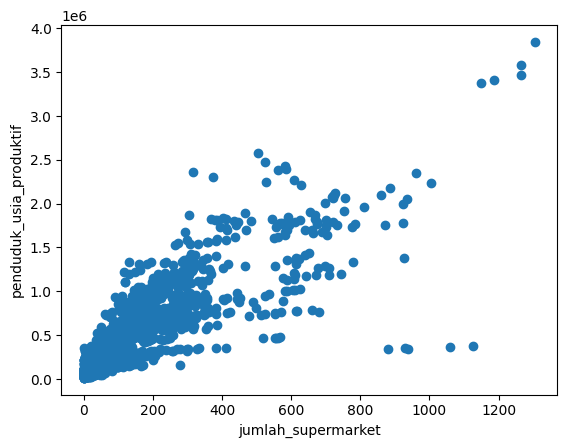

In [32]:
plt.scatter(main_df['jumlah_supermarket'], main_df['penduduk_usia_produktif'])
plt.xlabel('jumlah_supermarket')
plt.ylabel('penduduk_usia_produktif')
plt.show()

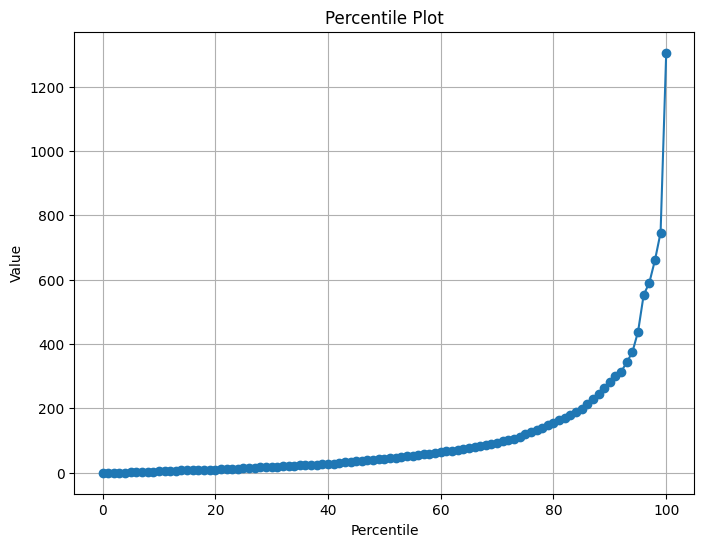

In [33]:
percentiles = np.percentile(main_df['jumlah_supermarket'], np.arange(0, 101, 1))

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 101, 1), percentiles, marker='o', linestyle='-')
plt.title('Percentile Plot')
plt.xlabel('Percentile')
plt.ylabel('Value')
plt.grid(True)
plt.show()

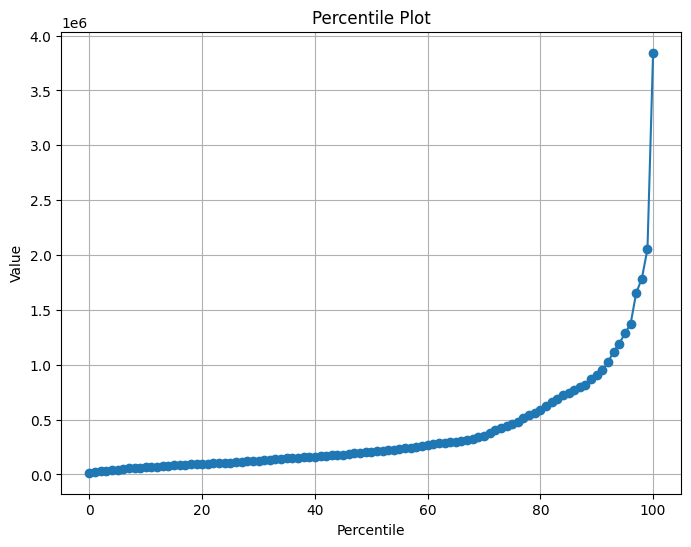

In [34]:
percentiles = np.percentile(main_df['penduduk_usia_produktif'], np.arange(0, 101, 1))

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 101, 1), percentiles, marker='o', linestyle='-')
plt.title('Percentile Plot')
plt.xlabel('Percentile')
plt.ylabel('Value')
plt.grid(True)
plt.show()

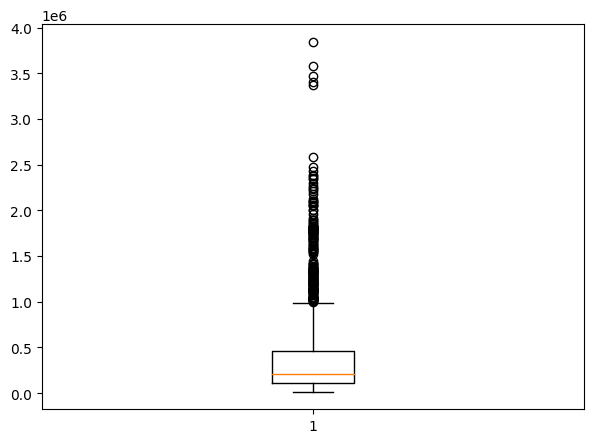

percentile 80%: 590633.0000000002
percentile 20%: 94148.0


In [35]:
fig = plt.figure(figsize =(7, 5))
 
plt.boxplot(main_df['penduduk_usia_produktif'])
plt.show()
print("percentile 80%:", np.percentile(main_df['penduduk_usia_produktif'], 80))
print("percentile 20%:", np.percentile(main_df['penduduk_usia_produktif'], 20))

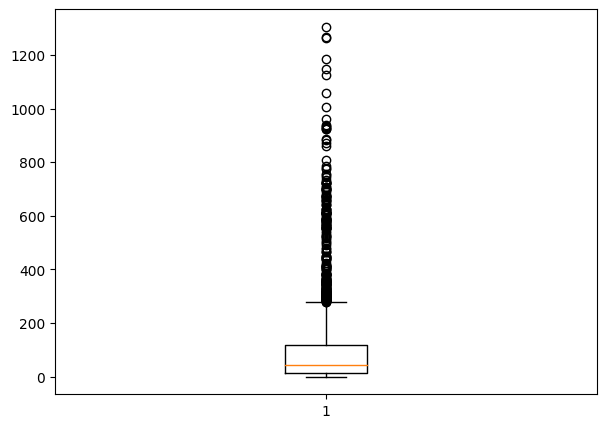

percentile 80%: 156.0
percentile 20%: 10.0


In [36]:
fig = plt.figure(figsize =(7, 5))
 
plt.boxplot(main_df['jumlah_supermarket'])
plt.show()
print("percentile 80%:", np.percentile(main_df['jumlah_supermarket'], 80))
print("percentile 20%:", np.percentile(main_df['jumlah_supermarket'], 20))

In [37]:
df_cluster_pdrb = main_df[main_df['kota_kab'].isin(main_df[main_df['penduduk_usia_produktif']>=np.percentile(main_df['penduduk_usia_produktif'], 80)]['kota_kab'].unique())]
df_cluster_pdrb['cluster'] = 4.
df_cluster = main_df[~main_df['kota_kab'].isin(df_cluster_pdrb['kota_kab'].unique())]
df_cluster_supermarket = df_cluster[df_cluster['kota_kab'].isin(main_df[main_df['jumlah_supermarket']>=np.percentile(main_df['jumlah_supermarket'], 80)]['kota_kab'].unique())]
df_cluster_supermarket['cluster'] = 5.
df_cluster = df_cluster[~df_cluster['kota_kab'].isin(df_cluster_supermarket['kota_kab'].unique())]

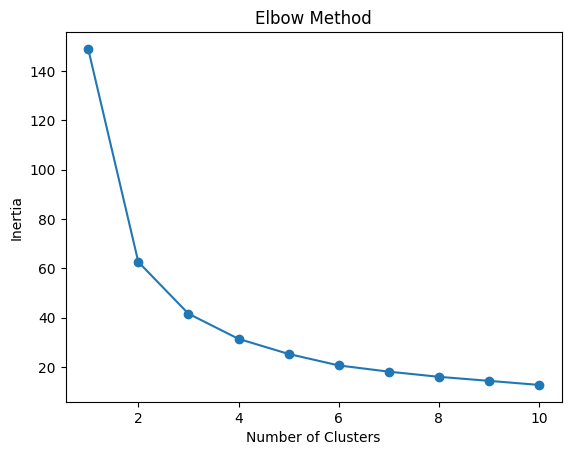

In [38]:
scaler = MinMaxScaler()
df_cluster['jumlah_supermarket_norm'] = scaler.fit_transform(df_cluster[['jumlah_supermarket']])
df_cluster['penduduk_usia_produktif_norm'] = scaler.fit_transform(df_cluster[['penduduk_usia_produktif']])

from sklearn.cluster import KMeans

data = list(zip(df_cluster['jumlah_supermarket_norm'], df_cluster['penduduk_usia_produktif_norm']))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

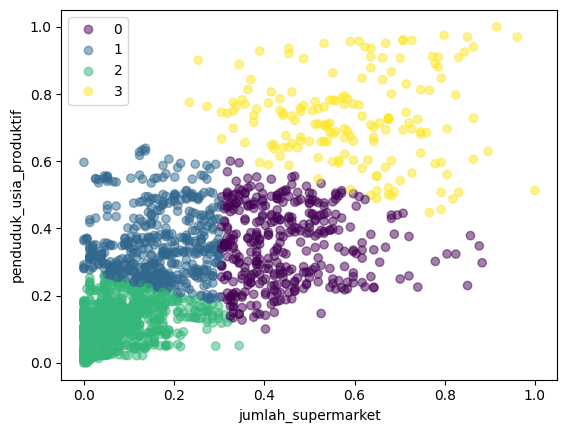

In [39]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(data)

scatter = plt.scatter(df_cluster['jumlah_supermarket_norm'], df_cluster['penduduk_usia_produktif_norm'], c=kmeans.labels_, alpha=0.5)
plt.xlabel('jumlah_supermarket')
plt.ylabel('penduduk_usia_produktif')
plt.legend(*scatter.legend_elements())
plt.show()

In [40]:
df_cluster['cluster'] = kmeans.labels_
ncluster = pd.DataFrame(df_cluster.groupby('kota_kab')['cluster'].nunique().sort_values(ascending=False)).reset_index()
ncluster.columns = ['kota_kab', 'ncluster']

list_kab_morethan1cluster = ncluster[ncluster['ncluster']>1]['kota_kab'].unique().tolist()

df_kab_morethan1cluster = df_cluster[df_cluster['kota_kab'].isin(list_kab_morethan1cluster)].sort_values(by=['kota_kab','year']).copy()
df_kab_morethan1cluster = df_kab_morethan1cluster.drop_duplicates(subset='kota_kab',keep='first')
df_kab_morethan1cluster = df_kab_morethan1cluster[['kota_kab','cluster']]
df_kab_morethan1cluster.columns = ['kota_kab','new_cluster']

df_cluster = df_cluster.merge(df_kab_morethan1cluster, on='kota_kab', how='left')
df_cluster['cluster'] = np.where(~df_cluster['new_cluster'].isna(), df_cluster['new_cluster'], df_cluster['cluster'])
df_cluster = df_cluster.drop(columns = 'new_cluster')

df_clustered = pd.concat([df_cluster, df_cluster_pdrb, df_cluster_supermarket])
df_clustered = df_clustered.drop_duplicates()

df = main_df.merge(df_clustered.loc[:,['year','provinsi','kota_kab','cluster']],on=['year','provinsi','kota_kab'], how='left')
df = df.drop_duplicates()

df['cluster'].value_counts().sort_index()

cluster
0.0    280
1.0    530
2.0    855
3.0    155
4.0    510
5.0    150
Name: count, dtype: int64

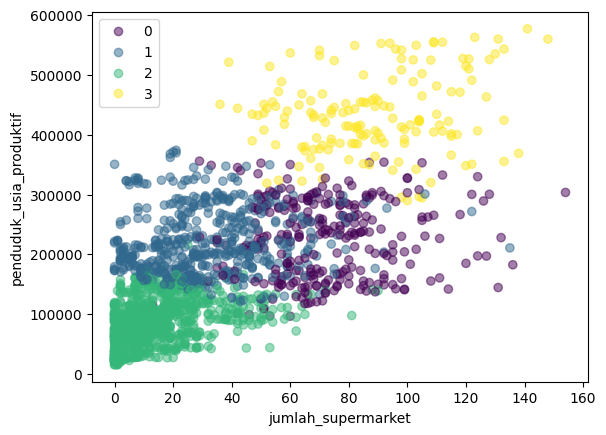

In [41]:
scatter = plt.scatter(df[df['cluster']<=3]['jumlah_supermarket'], df[df['cluster']<=3]['penduduk_usia_produktif'], c=df[df['cluster']<=3]['cluster'], alpha=0.5)
plt.xlabel('jumlah_supermarket')
plt.ylabel('penduduk_usia_produktif')
plt.legend(*scatter.legend_elements())
plt.show()

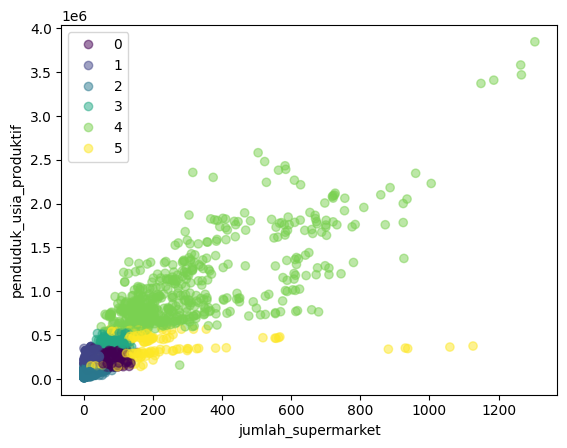

In [42]:
scatter = plt.scatter(df['jumlah_supermarket'], df['penduduk_usia_produktif'], c=df['cluster'], alpha=0.5)
plt.xlabel('jumlah_supermarket')
plt.ylabel('penduduk_usia_produktif')
plt.legend(*scatter.legend_elements())
plt.show()

In [43]:
df = df.loc[:,['year', 'provinsi', 'kota_kab', 'inflasi', 'akses_internet', 'penduduk_usia_produktif', 'indeks_harga_konsumen', 'jumlah_supermarket', 
               'total_pengeluaran_pertahun', 'persentase_ecommerce_menjual_kosmetik', 'jumlah_industri_kosmetik', 'pdrb_industri_kimia_farmasi_dan_obat_tradisional', 
               'penduduk_perempuan', 'pdrb_perkapita', 'lipstik_search_volume', 'emina_search_volume', 'cluster', 'sum_sales', 'sales_qty', 'unique_seller']].sort_values(['year', 'provinsi', 'kota_kab'])
df.head()

,year,provinsi,kota_kab,inflasi,akses_internet,penduduk_usia_produktif,indeks_harga_konsumen,jumlah_supermarket,total_pengeluaran_pertahun,persentase_ecommerce_menjual_kosmetik,jumlah_industri_kosmetik,pdrb_industri_kimia_farmasi_dan_obat_tradisional,penduduk_perempuan,pdrb_perkapita,lipstik_search_volume,emina_search_volume,cluster,sum_sales,sales_qty,unique_seller
0,2019.0,Aceh,Kab. Aceh Barat,2.160954,32.06,132615.0,98.614247,30.0,7.118597e+10,14.130118,11.0,3.279498e+10,103058.0,3.100305e+07,0.0,0.0,2.0,57990917.0,1699.0,9.0
5,2019.0,Aceh,Kab. Aceh Barat Daya,2.160954,24.56,105916.0,96.642449,7.0,2.779857e+10,14.130118,11.0,2.420343e+10,74107.0,1.995573e+07,0.0,0.0,2.0,51111958.0,1965.0,2.0
10,2019.0,Aceh,Kab. Aceh Besar,2.160954,39.79,252073.0,96.642449,71.0,1.019804e+11,14.130118,11.0,7.098745e+10,208797.0,2.305723e+07,0.0,0.0,0.0,2005565.0,49.0,3.0
15,2019.0,Aceh,Kab. Aceh Jaya,2.160954,25.79,59756.0,96.642449,10.0,2.289337e+10,14.130118,11.0,2.101459e+10,45575.0,2.162719e+07,0.0,0.0,2.0,4472400.0,61.0,3.0
20,2019.0,Aceh,Kab. Aceh Selatan,2.160954,21.62,163465.0,96.642449,27.0,5.888590e+10,14.130118,11.0,4.381378e+10,117640.0,1.746696e+07,0.0,0.0,1.0,95000.0,2.0,2.0


In [44]:
df.shape

(2480, 20)

In [45]:
df.groupby('year')['total_pengeluaran_pertahun'].sum()

year
2019.0    8.091065e+13
2020.0    8.670579e+13
2021.0    9.539909e+13
2022.0    1.048303e+14
2023.0    1.160723e+14
Name: total_pengeluaran_pertahun, dtype: float64

In [46]:
df.to_csv('040424_ads_cosmetic_industry_cagr.csv', index = False)

# Pipeline Model

In [44]:
random.seed(0)

def dev_best_model(df,curr_period,random_state=0):
    df_curr = df[df['year']<=curr_period]  
    X = df_curr.drop(['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun'],axis=1)
    y = df_curr['pengeluaran_perkapita_pertahun']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Define a function to train and evaluate a model with hyperparameters
    def objective(trial):
        # model_name = trial.suggest_categorical("model", ["LinearRegression"])
        model_name = trial.suggest_categorical("model", ["LinearRegression", "DecisionTree", "RandomForest", "LightGBM", "XGBoost"])

        if model_name == "LinearRegression":
            model = LinearRegression()
        elif model_name == "DecisionTree":
            max_depth = trial.suggest_int("max_depth", 2, 5)
            model = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
        elif model_name == "RandomForest":
            n_estimators = trial.suggest_int("n_estimators", 10, 100)
            max_depth = trial.suggest_int("max_depth", 2, 5)
            model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        elif model_name == "LightGBM":
            max_depth = trial.suggest_int("max_depth", 2, 10)
            n_estimators = trial.suggest_int("n_estimators", 5, 100)
            model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, verbose=-1)
        elif model_name == "XGBoost":
            n_estimators = trial.suggest_int("n_estimators", 5, 100)
            max_depth = trial.suggest_int("max_depth", 2, 10)
            model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, seed=random_state)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        error = mean_absolute_percentage_error(y_test, y_pred)
        return error

    # Create an Optuna study
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state))

    # Optimize the hyperparameters
    optuna.logging.disable_default_handler()
    study.optimize(objective, n_trials=100)

    # Get the best hyperparameters
    best_params = study.best_params

    # Train the best model with the found hyperparameters
    best_model = None
    if best_params["model"] == "LinearRegression":
        best_model = LinearRegression()
    elif best_params["model"] == "DecisionTree":
        best_model = DecisionTreeRegressor(max_depth=best_params["max_depth"], random_state=random_state)
    elif best_params["model"] == "RandomForest":
        best_model = RandomForestRegressor(n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], random_state=random_state)
    elif best_params["model"] == "LightGBM":
        best_model = LGBMRegressor(n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], random_state=random_state, verbose=-1)
    elif best_params["model"] == "XGBoost":
        best_model = XGBRegressor(n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], seed=random_state)

    best_model.fit(X_train, y_train)

    # Evaluate the best model
    y_pred = best_model.predict(X_test)
    
    def eval_model(y_actual,y_prediction):
        mse = np.round(mean_squared_error(y_actual, y_prediction),1)
        mae = np.round(mean_absolute_error(y_actual, y_prediction),1)
        mape= np.round(mean_absolute_percentage_error(y_actual, y_prediction)*100,1)
        
        return mse, mae, mape
    
    curr_mse, curr_mae, curr_mape = eval_model(y_test,y_pred)    
    
    best_params_new = best_params.copy()
    del best_params_new['model']
    
    df_next = df[df['year']==curr_period+1]  
    X_next = df_next.drop(['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun'],axis=1)
    y_next = df_next['pengeluaran_perkapita_pertahun']
    
    if df_next.shape[0] > 0:
        y_pred_next = best_model.predict(X_next)
        next_mse, next_mae, next_mape = eval_model(y_next,y_pred_next)
    else:
        next_mse, next_mae, next_mape = np.NaN, np.NaN, np.NaN
    
    df_eval = pd.DataFrame({'Period':curr_period, 'Best_Model':best_params['model'], 'Best_Param':[str(best_params_new)],
                            'Curr_MSE':curr_mse, 'Curr_MAE':curr_mae, 'Curr_MAPE':curr_mape,
                            'Next_MSE':next_mse, 'Next_MAE':next_mae, 'Next_MAPE':next_mape
                           })
    
    if best_params["model"] == "LinearRegression":
        importance = best_model.coef_
        feature_names = df.drop(['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun'],axis=1).columns
        feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': importance}).sort_values(by='Coefficient', ascending=False)
    else:
        importance = best_model.feature_importances_
        feature_names = df.drop(['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun'],axis=1).columns
        feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

    return best_model, df_eval, feature_importance

In [45]:
def pred_function_dynamic(df,year):
    var = df.drop(['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun'],axis=1).columns
    
    df = df[df['year']==year]
    
    if year==2019:
        model=model_19
    elif year==2020:
        model=model_19
    elif year==2021:
        model=model_20
    elif year==2022:
        model=model_21
    elif year==2023:
        model=model_22
    
    df['prediction'] = model.predict(df[var])
    df = df[['year', 'provinsi', 'kota_kab', 'cluster','prediction']]
    
    return df

# Modelling

In [46]:
df_used = df.loc[:, ~df.columns.isin(['year', 'provinsi', 'kota_kab', 'cluster', 'pengeluaran_perkapita_pertahun'])]

vif_data = pd.DataFrame() 
vif_data["feature"] = df_used.columns

for i in range(len(df_used.columns)):
    vif_data.loc[i, "VIF"] = variance_inflation_factor(df_used.values, i)

vif_data = vif_data.sort_values('VIF')

while vif_data['VIF'].iloc[-1] > 5:
    df_used = df_used.drop(columns=vif_data['feature'].iloc[-1])
    
    vif_data = pd.DataFrame() 
    vif_data["feature"] = df_used.columns
    for i in range(len(df_used.columns)):
        vif_data.loc[i, "VIF"] = variance_inflation_factor(df_used.values, i)
    
    vif_data = vif_data.sort_values('VIF')

vif_data

,feature,VIF
7,sum_sales,1.443934
6,emina_search_volume,1.617141
4,pdrb_perkapita,1.739778
5,lipstik_search_volume,2.031890
0,inflasi,2.109961
3,jumlah_industri_kosmetik,2.183915
1,jumlah_supermarket,2.632977
2,persentase_ecommerce_menjual_kosmetik,2.655809


In [47]:
predictor_columns = vif_data['feature'].tolist()

formula = 'pengeluaran_perkapita_pertahun ~ ' + ' + '.join(predictor_columns)

model = sm.formula.ols(formula, data=df).fit()
print(model.summary())

                                           OLS Regression Results                                           
Dep. Variable:     pdrb_industri_kimia_farmasi_dan_obat_tradisional   R-squared:                       0.432
Model:                                                          OLS   Adj. R-squared:                  0.431
Method:                                               Least Squares   F-statistic:                     225.4
Date:                                              Thu, 29 Feb 2024   Prob (F-statistic):          2.02e-284
Time:                                                      10:18:20   Log-Likelihood:                -69577.
No. Observations:                                              2375   AIC:                         1.392e+05
Df Residuals:                                                  2366   BIC:                         1.392e+05
Df Model:                                                         8                                         
Covariance Type:   

In [48]:
selected_columns = ['year', 'provinsi', 'kota_kab', 'cluster', 'pengeluaran_perkapita_pertahun'] + predictor_columns
selected_columns.remove('emina_search_volume')
selected_columns.remove('lipstik_search_volume')
selected_columns.remove('inflasi')
selected_columns.remove('persentase_ecommerce_menjual_kosmetik')

df_used = df.loc[:, selected_columns]
df_used.head()

,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
0,2019.0,Aceh,Kab. Aceh Barat,2.0,3.244242e+10,57990917.0,2.951394e+07,11.0,30.0
5,2019.0,Aceh,Kab. Aceh Barat Daya,1.0,2.352648e+10,51111958.0,1.903004e+07,11.0,7.0
10,2019.0,Aceh,Kab. Aceh Besar,0.0,6.864003e+10,2005565.0,2.181323e+07,11.0,71.0
15,2019.0,Aceh,Kab. Aceh Jaya,1.0,2.092952e+10,4472400.0,2.087664e+07,11.0,10.0
20,2019.0,Aceh,Kab. Aceh Selatan,1.0,4.143376e+10,95000.0,1.624412e+07,11.0,27.0


## Cluster 0

In [49]:
df0 = df_used[df_used['cluster']==0]
print(df0.shape)
df0.head()

(215, 9)


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
10,2019.0,Aceh,Kab. Aceh Besar,0.0,6.864003e+10,2005565.0,2.181323e+07,11.0,71.0
50,2019.0,Aceh,Kab. Aceh Utara,0.0,5.134323e+11,1471499.0,2.614463e+07,11.0,71.0
610,2019.0,Bali,Kab. Karangasem,0.0,4.816723e+09,3696394.0,2.809455e+07,27.0,95.0
725,2019.0,Bali,Kab. Klungkung,0.0,5.815457e+09,280000.0,3.267884e+07,27.0,72.0
1260,2019.0,Banten,Kab. Pandeglang,0.0,2.801923e+11,95636705.0,1.634472e+07,90.0,156.0


In [50]:
df0['year'].value_counts()

year
2019.0    43
2020.0    43
2021.0    43
2022.0    43
2023.0    43
Name: count, dtype: int64

In [51]:
model_19, eval_19, _19 = dev_best_model(df0,2019)
model_20, eval_20, _20 = dev_best_model(df0,2020)
model_21, eval_21, _21 = dev_best_model(df0,2021)
model_22, eval_22, _22 = dev_best_model(df0,2022)
model_23, eval_23, _23 = dev_best_model(df0,2023)

summ_eval = pd.concat([eval_19,eval_20,eval_21,eval_22,eval_23],axis=0)
summ_eval['avg_mape'] = summ_eval[['Curr_MAPE', 'Next_MAPE']].mean(axis=1)
summ_eval

[I 2024-02-29 10:18:21,022] A new study created in memory with name: no-name-a8f2aad4-4a21-4368-a6af-787378dac79e


,Period,Best_Model,Best_Param,Curr_MSE,Curr_MAE,Curr_MAPE,Next_MSE,Next_MAE,Next_MAPE,avg_mape
0,2019,XGBoost,"{'n_estimators': 88, 'max_depth': 10}",6.561921e+22,1.668925e+11,16141.2,1.807628e+22,6.404785e+10,3050.9,9596.05
0,2020,LinearRegression,{},2.263130e+22,1.138731e+11,18714.3,2.258298e+22,1.099683e+11,9572.4,14143.35
0,2021,DecisionTree,{'max_depth': 2},1.160430e+22,7.882348e+10,16012.5,1.346757e+22,8.469343e+10,13702.5,14857.50
0,2022,DecisionTree,{'max_depth': 4},7.687518e+21,5.362415e+10,248.2,8.238044e+21,5.440680e+10,880.7,564.45
0,2023,DecisionTree,{'max_depth': 4},8.301589e+21,5.541583e+10,126.3,NaN,NaN,NaN,126.30


In [52]:
display(_19, _20, _21, _22, _23)

,Feature,Importance
2,jumlah_industri_kosmetik,0.574349
0,sum_sales,0.238223
3,jumlah_supermarket,0.130423
1,pdrb_perkapita,0.057006


,Feature,Coefficient
3,jumlah_supermarket,1.755180e+09
2,jumlah_industri_kosmetik,7.002366e+08
0,sum_sales,-4.856519e+01
1,pdrb_perkapita,-2.320423e+02


,Feature,Importance
1,pdrb_perkapita,0.504768
2,jumlah_industri_kosmetik,0.384628
0,sum_sales,0.110604
3,jumlah_supermarket,0.000000


,Feature,Importance
0,sum_sales,0.377445
1,pdrb_perkapita,0.303957
2,jumlah_industri_kosmetik,0.242237
3,jumlah_supermarket,0.076361


,Feature,Importance
1,pdrb_perkapita,0.335354
0,sum_sales,0.325239
2,jumlah_industri_kosmetik,0.269056
3,jumlah_supermarket,0.070350


In [53]:
df_pred_hist0 = df0[['year', 'provinsi', 'kota_kab', 'cluster']].head(0)
df_pred_hist0['prediction'] = []
for year in range(2019,2024):
    df_temp = pred_function_dynamic(df0,year) #opsi _dynamic
    df_pred_hist0 = pd.concat([df_pred_hist0,df_temp])

df_pred_hist0 = df0[['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun']].merge(df_pred_hist0, on=['year','provinsi','kota_kab','cluster'],how='left')
df_pred_hist0['APE'] = abs((df_pred_hist0['prediction'] - df_pred_hist0['pengeluaran_perkapita_pertahun']) / df_pred_hist0['pengeluaran_perkapita_pertahun'])*100 
df_pred_hist0 = df_pred_hist0[~np.isinf(df_pred_hist0['APE'])]

print('Error Below 30%:', df_pred_hist0[df_pred_hist0['APE']<30].shape[0], '\nError Above 30%:', df_pred_hist0[df_pred_hist0['APE']>=30].shape[0])
df_pred_hist0[df_pred_hist0['APE']>20].sort_values('APE', ascending = False)

Error Below 30%: 83 
Error Above 30%: 132


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE
164,2022.0,Sulawesi Tenggara,Kab. Bombana,0.0,3.058466e+07,1.163872e+11,380441.241281
116,2021.0,Nusa Tenggara Barat,Kab. Lombok Utara,0.0,2.651177e+07,6.853754e+10,258417.387405
159,2022.0,Nusa Tenggara Barat,Kab. Lombok Utara,0.0,3.078228e+07,4.407330e+10,143077.472449
30,2019.0,Nusa Tenggara Barat,Kab. Lombok Utara,0.0,2.151625e+07,2.962987e+10,137609.245724
73,2020.0,Nusa Tenggara Barat,Kab. Lombok Utara,0.0,2.847765e+07,3.447538e+10,120961.181536
...,...,...,...,...,...,...,...
124,2021.0,Sumatera Selatan,Kab. Ogan Komering Ilir,0.0,1.187145e+11,1.504004e+11,26.690864
101,2021.0,Jawa Timur,Kab. Bondowoso,0.0,3.110773e+11,2.357174e+11,24.225463
157,2022.0,Lampung,Kab. Lampung Utara,0.0,9.450446e+10,1.163872e+11,23.155271
56,2020.0,Jawa Tengah,Kab. Temanggung,0.0,2.678187e+11,2.061959e+11,23.009141


In [54]:
df_pred_hist0[~np.isinf(df_pred_hist0['APE'])]

,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE
0,2019.0,Aceh,Kab. Aceh Besar,0.0,6.864003e+10,6.864003e+10,0.000007
1,2019.0,Aceh,Kab. Aceh Utara,0.0,5.134323e+11,5.134321e+11,0.000048
2,2019.0,Bali,Kab. Karangasem,0.0,4.816723e+09,4.816728e+09,0.000088
3,2019.0,Bali,Kab. Klungkung,0.0,5.815457e+09,5.815459e+09,0.000027
4,2019.0,Banten,Kab. Pandeglang,0.0,2.801923e+11,1.248075e+11,55.456466
...,...,...,...,...,...,...,...
210,2023.0,Sumatera Selatan,Kab. Ogan Komering Ilir,0.0,1.433708e+11,1.483558e+11,3.476998
211,2023.0,Sumatera Selatan,Kab. Ogan Komering Ulu,0.0,1.942895e+11,4.569814e+10,76.479355
212,2023.0,Sumatera Selatan,Kab. Ogan Komering Ulu Timur,0.0,9.177504e+10,4.569814e+10,50.206357
213,2023.0,Sumatera Utara,Kab. Langkat,0.0,1.061790e+11,4.569814e+10,56.961215


In [55]:
df_error0 = df_pred_hist0.dropna().merge(df_used, on=['year','provinsi','kota_kab','cluster'], how='left').drop(
                        columns = 'pengeluaran_perkapita_pertahun_y').rename(columns = {'pengeluaran_perkapita_pertahun_x':'pengeluaran_perkapita_pertahun'})
df_error0[df_error0['kota_kab'].isin(df_pred_hist0[df_pred_hist0['APE']>30].sort_values(
    'APE', ascending = False)['kota_kab'].unique())].sort_values(['kota_kab', 'year'])

,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
0,2019.0,Aceh,Kab. Aceh Besar,0.0,6.864003e+10,6.864003e+10,0.000007,2005565.0,2.181323e+07,11.0,71.0
43,2020.0,Aceh,Kab. Aceh Besar,0.0,6.315009e+10,2.810971e+10,55.487453,2005565.0,2.206900e+07,12.0,82.0
86,2021.0,Aceh,Kab. Aceh Besar,0.0,6.221444e+10,1.325296e+11,113.020686,2005565.0,2.232776e+07,13.0,105.0
129,2022.0,Aceh,Kab. Aceh Besar,0.0,6.205332e+10,4.407330e+10,28.975123,2005565.0,2.258956e+07,13.0,109.0
172,2023.0,Aceh,Kab. Aceh Besar,0.0,6.000134e+10,3.213083e+10,46.449806,2005565.0,2.285443e+07,14.0,126.0
...,...,...,...,...,...,...,...,...,...,...,...
9,2019.0,Jawa Barat,Kota Sukabumi,0.0,2.774406e+10,2.774410e+10,0.000150,973592467.0,2.314243e+07,190.0,59.0
52,2020.0,Jawa Barat,Kota Sukabumi,0.0,3.293577e+10,2.774410e+10,15.763001,973592467.0,2.228721e+07,213.0,63.0
95,2021.0,Jawa Barat,Kota Sukabumi,0.0,3.545666e+10,1.848051e+11,421.214052,973592467.0,2.153823e+07,240.0,71.0
138,2022.0,Jawa Barat,Kota Sukabumi,0.0,3.565462e+10,1.661971e+11,366.130744,973592467.0,2.067041e+07,269.0,72.0


## Cluster 1

In [56]:
df1 = df_used[df_used['cluster']==1]
print(df1.shape)
df1.head()

(640, 9)


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
5,2019.0,Aceh,Kab. Aceh Barat Daya,1.0,2.352648e+10,51111958.0,1.903004e+07,11.0,7.0
15,2019.0,Aceh,Kab. Aceh Jaya,1.0,2.092952e+10,4472400.0,2.087664e+07,11.0,10.0
20,2019.0,Aceh,Kab. Aceh Selatan,1.0,4.143376e+10,95000.0,1.624412e+07,11.0,27.0
25,2019.0,Aceh,Kab. Aceh Singkil,1.0,2.374365e+10,4472400.0,1.310135e+07,11.0,17.0
30,2019.0,Aceh,Kab. Aceh Tamiang,1.0,1.044817e+11,4472400.0,1.944803e+07,11.0,29.0


In [57]:
df1['year'].value_counts()

year
2019.0    128
2020.0    128
2021.0    128
2022.0    128
2023.0    128
Name: count, dtype: int64

In [58]:
model_19, eval_19, _19 = dev_best_model(df1,2019)
model_20, eval_20, _20 = dev_best_model(df1,2020)
model_21, eval_21, _21 = dev_best_model(df1,2021)
model_22, eval_22, _22 = dev_best_model(df1,2022)
model_23, eval_23, _23 = dev_best_model(df1,2023)

summ_eval = pd.concat([eval_19,eval_20,eval_21,eval_22,eval_23],axis=0)
summ_eval['avg_mape'] = summ_eval[['Curr_MAPE', 'Next_MAPE']].mean(axis=1)
summ_eval

,Period,Best_Model,Best_Param,Curr_MSE,Curr_MAE,Curr_MAPE,Next_MSE,Next_MAE,Next_MAPE,avg_mape
0,2019,XGBoost,"{'n_estimators': 49, 'max_depth': 9}",4.267950e+20,1.042891e+10,2631.4,1.819151e+20,5.865355e+09,1851.6,2241.50
0,2020,XGBoost,"{'n_estimators': 22, 'max_depth': 9}",1.369782e+20,3.372822e+09,219.8,2.337686e+20,6.599013e+09,1828.7,1024.25
0,2021,XGBoost,"{'n_estimators': 94, 'max_depth': 6}",6.523841e+19,4.148734e+09,1000.3,1.401225e+20,6.622313e+09,2956.9,1978.60
0,2022,XGBoost,"{'n_estimators': 28, 'max_depth': 10}",1.185963e+20,4.268508e+09,1018.7,1.000092e+20,5.182463e+09,2005.5,1512.10
0,2023,XGBoost,"{'n_estimators': 78, 'max_depth': 10}",9.221795e+19,3.090260e+09,828.8,NaN,NaN,NaN,828.80


In [59]:
display(_19, _20, _21, _22, _23)

,Feature,Importance
3,jumlah_supermarket,0.500546
0,sum_sales,0.228719
1,pdrb_perkapita,0.146611
2,jumlah_industri_kosmetik,0.124123


,Feature,Importance
3,jumlah_supermarket,0.435408
2,jumlah_industri_kosmetik,0.347869
0,sum_sales,0.143183
1,pdrb_perkapita,0.073539


,Feature,Importance
2,jumlah_industri_kosmetik,0.369913
0,sum_sales,0.345770
3,jumlah_supermarket,0.191344
1,pdrb_perkapita,0.092973


,Feature,Importance
3,jumlah_supermarket,0.332052
0,sum_sales,0.293137
2,jumlah_industri_kosmetik,0.281854
1,pdrb_perkapita,0.092957


,Feature,Importance
0,sum_sales,0.461522
2,jumlah_industri_kosmetik,0.300979
3,jumlah_supermarket,0.161244
1,pdrb_perkapita,0.076254


In [60]:
df_pred_hist1 = df1[['year', 'provinsi', 'kota_kab', 'cluster']].head(0)
df_pred_hist1['prediction'] = []
for year in range(2019,2024):
    df_temp = pred_function_dynamic(df1,year) #opsi _dynamic
    df_pred_hist1 = pd.concat([df_pred_hist1,df_temp])

df_pred_hist1 = df1[['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun']].merge(df_pred_hist1, on=['year','provinsi','kota_kab','cluster'],how='left')
df_pred_hist1['APE'] = abs((df_pred_hist1['prediction'] - df_pred_hist1['pengeluaran_perkapita_pertahun']) / df_pred_hist1['pengeluaran_perkapita_pertahun'])*100 
df_pred_hist1 = df_pred_hist1[~np.isinf(df_pred_hist1['APE'])]

print('Error Below 30%:', df_pred_hist1[df_pred_hist1['APE']<30].shape[0], '\nError Above 30%:', df_pred_hist1[df_pred_hist1['APE']>=30].shape[0])
df_pred_hist1[df_pred_hist1['APE']>20].sort_values('APE', ascending = False)

Error Below 30%: 246 
Error Above 30%: 394


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE
468,2022.0,Papua,Kab. Yalimo,1.0,1.064464e+06,-7.028370e+08,66127.309480
470,2022.0,Papua Barat,Kab. Tambrauw,1.0,2.053500e+05,1.279535e+08,62209.949390
459,2022.0,Papua,Kab. Mamberamo Tengah,1.0,9.297218e+05,5.207480e+08,55911.167762
332,2021.0,Papua,Kab. Mappi,1.0,1.718563e+07,7.925744e+09,46018.432970
529,2023.0,Gorontalo,Kab. Gorontalo Utara,1.0,3.354631e+07,1.342403e+10,39916.425965
...,...,...,...,...,...,...,...
156,2020.0,Kalimantan Selatan,Kab. Barito Kuala,1.0,1.846942e+10,1.467741e+10,20.531282
319,2021.0,Nusa Tenggara Timur,Kab. Sumba Barat,1.0,6.613707e+08,5.268403e+08,20.341158
377,2021.0,Sumatera Utara,Kab. Nias Selatan,1.0,1.862867e+08,2.238977e+08,20.189797
312,2021.0,Nusa Tenggara Timur,Kab. Manggarai Barat,1.0,2.551642e+08,2.039431e+08,20.073763


In [61]:
df_error1 = df_pred_hist1.dropna().merge(df_used, on=['year','provinsi','kota_kab','cluster'], how='left').drop(
                        columns = 'pengeluaran_perkapita_pertahun_y').rename(columns = {'pengeluaran_perkapita_pertahun_x':'pengeluaran_perkapita_pertahun'})
df_error1[df_error1['kota_kab'].isin(df_pred_hist1[df_pred_hist1['APE']>30].sort_values(
    'APE', ascending = False)['kota_kab'].unique())].sort_values(['kota_kab', 'year'])

,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
1,2019.0,Aceh,Kab. Aceh Jaya,1.0,2.092952e+10,2.092897e+10,0.002655,4472400.0,2.087664e+07,11.0,10.0
129,2020.0,Aceh,Kab. Aceh Jaya,1.0,1.923614e+10,2.200380e+10,14.387815,4472400.0,2.067455e+07,12.0,12.0
257,2021.0,Aceh,Kab. Aceh Jaya,1.0,1.975092e+10,1.827153e+10,7.490244,4472400.0,2.047441e+07,13.0,17.0
385,2022.0,Aceh,Kab. Aceh Jaya,1.0,2.067637e+10,3.916712e+10,89.429371,4472400.0,2.027621e+07,13.0,16.0
513,2023.0,Aceh,Kab. Aceh Jaya,1.0,2.059267e+10,2.253126e+10,9.414006,4472400.0,2.007993e+07,14.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...
45,2019.0,Maluku,Kota Tual,1.0,1.419588e+07,1.303237e+07,8.196111,189000.0,2.019727e+07,1.0,3.0
173,2020.0,Maluku,Kota Tual,1.0,1.403563e+07,8.445010e+06,39.831630,189000.0,1.887004e+07,1.0,3.0
301,2021.0,Maluku,Kota Tual,1.0,1.399154e+07,-5.320239e+07,480.246765,189000.0,1.833091e+07,1.0,3.0
429,2022.0,Maluku,Kota Tual,1.0,1.425354e+07,-5.336196e+07,474.376807,189000.0,1.647150e+07,1.0,3.0


## Cluster 2

In [62]:
df2 = df_used[df_used['cluster']==2]
print(df2.shape)
df2.head()

(545, 9)


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
0,2019.0,Aceh,Kab. Aceh Barat,2.0,3.244242e+10,57990917.0,2.951394e+07,11.0,30.0
35,2019.0,Aceh,Kab. Aceh Tengah,2.0,2.658191e+10,2949300.0,2.638365e+07,11.0,12.0
205,2019.0,Aceh,Kab. Bener Meriah,2.0,2.483552e+10,1263000.0,2.472685e+07,11.0,7.0
1150,2019.0,Aceh,Kab. Nagan Raya,2.0,6.360596e+10,501497.0,3.674974e+07,11.0,30.0
2085,2019.0,Aceh,Kota Lhokseumawe,2.0,3.967470e+11,57491910.0,3.068089e+07,11.0,33.0


In [63]:
df2['year'].value_counts()

year
2019.0    109
2020.0    109
2021.0    109
2022.0    109
2023.0    109
Name: count, dtype: int64

In [64]:
model_19, eval_19, _19 = dev_best_model(df2,2019)
model_20, eval_20, _20 = dev_best_model(df2,2020)
model_21, eval_21, _21 = dev_best_model(df2,2021)
model_22, eval_22, _22 = dev_best_model(df2,2022)
model_23, eval_23, _23 = dev_best_model(df2,2023)

summ_eval = pd.concat([eval_19,eval_20,eval_21,eval_22,eval_23],axis=0)
summ_eval['avg_mape'] = summ_eval[['Curr_MAPE', 'Next_MAPE']].mean(axis=1)
summ_eval

,Period,Best_Model,Best_Param,Curr_MSE,Curr_MAE,Curr_MAPE,Next_MSE,Next_MAE,Next_MAPE,avg_mape
0,2019,XGBoost,"{'n_estimators': 49, 'max_depth': 9}",5.177157e+20,1.512481e+10,2235.8,2.054147e+21,2.070333e+10,32330.4,17283.10
0,2020,XGBoost,"{'n_estimators': 100, 'max_depth': 10}",7.626975e+20,1.318409e+10,975.4,9.471024e+20,1.359837e+10,6625.2,3800.30
0,2021,XGBoost,"{'n_estimators': 61, 'max_depth': 8}",6.546436e+20,1.283064e+10,847.9,7.321176e+20,1.498775e+10,4485.4,2666.65
0,2022,XGBoost,"{'n_estimators': 98, 'max_depth': 10}",4.003642e+21,2.189601e+10,3038.3,1.047186e+21,1.616306e+10,4172.5,3605.40
0,2023,XGBoost,"{'n_estimators': 22, 'max_depth': 9}",4.256609e+20,9.326986e+09,2003.9,NaN,NaN,NaN,2003.90


In [65]:
display(_19, _20, _21, _22, _23)

,Feature,Importance
0,sum_sales,0.466577
3,jumlah_supermarket,0.304053
1,pdrb_perkapita,0.151991
2,jumlah_industri_kosmetik,0.077378


,Feature,Importance
0,sum_sales,0.607899
2,jumlah_industri_kosmetik,0.171438
3,jumlah_supermarket,0.158512
1,pdrb_perkapita,0.062151


,Feature,Importance
0,sum_sales,0.404284
2,jumlah_industri_kosmetik,0.270097
3,jumlah_supermarket,0.199174
1,pdrb_perkapita,0.126445


,Feature,Importance
0,sum_sales,0.467741
3,jumlah_supermarket,0.270943
2,jumlah_industri_kosmetik,0.171787
1,pdrb_perkapita,0.089529


,Feature,Importance
0,sum_sales,0.575593
3,jumlah_supermarket,0.169332
2,jumlah_industri_kosmetik,0.149288
1,pdrb_perkapita,0.105786


In [66]:
df_pred_hist2 = df2[['year', 'provinsi', 'kota_kab', 'cluster']].head(0)
df_pred_hist2['prediction'] = []
for year in range(2019,2024):
    df_temp = pred_function_dynamic(df2,year) #opsi _dynamic
    df_pred_hist2 = pd.concat([df_pred_hist2,df_temp])

df_pred_hist2 = df2[['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun']].merge(df_pred_hist2, on=['year','provinsi','kota_kab','cluster'],how='left')
df_pred_hist2['APE'] = abs((df_pred_hist2['prediction'] - df_pred_hist2['pengeluaran_perkapita_pertahun']) / df_pred_hist2['pengeluaran_perkapita_pertahun'])*100 
df_pred_hist2 = df_pred_hist2[~np.isinf(df_pred_hist2['APE'])]

print('Error Below 30%:', df_pred_hist2[df_pred_hist2['APE']<30].shape[0], '\nError Above 30%:', df_pred_hist2[df_pred_hist2['APE']>=30].shape[0])
df_pred_hist2[df_pred_hist2['APE']>20].sort_values('APE', ascending = False)

Error Below 30%: 205 
Error Above 30%: 340


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE
152,2020.0,Papua Barat,Kab. Sorong Selatan,2.0,1.946233e+06,2.368431e+10,1.216831e+06
151,2020.0,Papua Barat,Kab. Raja Ampat,2.0,1.877322e+06,1.704904e+10,9.080575e+05
153,2020.0,Papua Barat,Kab. Teluk Wondama,2.0,2.578968e+06,1.711324e+10,6.634695e+05
258,2021.0,Papua Barat,Kab. Manokwari,2.0,3.649735e+07,1.383740e+11,3.790345e+05
284,2021.0,Sulawesi Tenggara,Kab. Konawe Kepulauan,2.0,4.635831e+06,9.403610e+09,2.027463e+05
...,...,...,...,...,...,...,...
162,2020.0,Sulawesi Selatan,Kab. Pinrang,2.0,1.143649e+09,8.872533e+08,2.241911e+01
467,2023.0,Lampung,Kab. Tulang Bawang Barat,2.0,9.054919e+10,7.058543e+10,2.204742e+01
251,2021.0,Maluku,Kab. Kepulauan Aru,2.0,4.327389e+07,3.420342e+07,2.096061e+01
134,2020.0,Kalimantan Tengah,Kab. Katingan,2.0,4.345899e+10,3.446525e+10,2.069479e+01


In [67]:
df_error2 = df_pred_hist2.dropna().merge(df_used, on=['year','provinsi','kota_kab','cluster'], how='left').drop(
                        columns = 'pengeluaran_perkapita_pertahun_y').rename(columns = {'pengeluaran_perkapita_pertahun_x':'pengeluaran_perkapita_pertahun'})
df_error2[df_error2['kota_kab'].isin(df_pred_hist2[df_pred_hist2['APE']>30].sort_values(
    'APE', ascending = False)['kota_kab'].unique())].sort_values(['kota_kab', 'year'])

,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
0,2019.0,Aceh,Kab. Aceh Barat,2.0,3.244242e+10,3.244082e+10,0.004928,57990917.0,2.951394e+07,11.0,30.0
109,2020.0,Aceh,Kab. Aceh Barat,2.0,2.911692e+10,7.165583e+10,146.096873,57990917.0,3.149215e+07,12.0,29.0
218,2021.0,Aceh,Kab. Aceh Barat,2.0,3.011815e+10,3.393667e+10,12.678479,57990917.0,3.360295e+07,13.0,25.0
327,2022.0,Aceh,Kab. Aceh Barat,2.0,3.140732e+10,3.011045e+10,4.129192,57990917.0,3.585523e+07,13.0,28.0
436,2023.0,Aceh,Kab. Aceh Barat,2.0,3.106967e+10,3.137544e+10,0.984125,57990917.0,3.825848e+07,14.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...
89,2019.0,Sumatera Barat,Lima Puluh Kota,2.0,1.078961e+09,1.077152e+09,0.167671,23267600.0,2.705420e+07,5.0,45.0
198,2020.0,Sumatera Barat,Lima Puluh Kota,2.0,1.032085e+09,1.077152e+09,4.366628,23267600.0,2.695640e+07,6.0,44.0
307,2021.0,Sumatera Barat,Lima Puluh Kota,2.0,8.375346e+08,1.055444e+09,26.017927,23267600.0,2.685896e+07,7.0,40.0
416,2022.0,Sumatera Barat,Lima Puluh Kota,2.0,8.388079e+08,1.250435e+09,49.072896,23267600.0,2.676188e+07,8.0,43.0


## Cluster 3

In [68]:
df3 = df_used[df_used['cluster']==3]
print(df3.shape)
df3.head()

(555, 9)


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
1900,2019.0,Aceh,Kota Banda Aceh,3.0,9.734535e+10,5.769721e+08,4.838062e+07,11.0,110.0
75,2019.0,Bali,Kab. Badung,3.0,1.715479e+10,1.011506e+08,5.026959e+07,27.0,881.0
2000,2019.0,Bali,Kota Denpasar,3.0,2.483864e+10,1.698807e+09,2.946305e+07,27.0,553.0
1985,2019.0,Banten,Kota Cilegon,3.0,9.589886e+12,1.193837e+08,1.584173e+08,90.0,144.0
2305,2019.0,Banten,Kota Tangerang,3.0,8.573738e+12,2.965023e+10,4.154867e+07,90.0,709.0


In [69]:
df3['year'].value_counts()

year
2019.0    111
2020.0    111
2021.0    111
2022.0    111
2023.0    111
Name: count, dtype: int64

In [70]:
model_19, eval_19, _19 = dev_best_model(df3,2019)
model_20, eval_20, _20 = dev_best_model(df3,2020)
model_21, eval_21, _21 = dev_best_model(df3,2021)
model_22, eval_22, _22 = dev_best_model(df3,2022)
model_23, eval_23, _23 = dev_best_model(df3,2023)

summ_eval = pd.concat([eval_19,eval_20,eval_21,eval_22,eval_23],axis=0)
summ_eval['avg_mape'] = summ_eval[['Curr_MAPE', 'Next_MAPE']].mean(axis=1)
summ_eval

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 4
[LightGBM] [Info] Start training from score 1233897000322.201660
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

,Period,Best_Model,Best_Param,Curr_MSE,Curr_MAE,Curr_MAPE,Next_MSE,Next_MAE,Next_MAPE,avg_mape
0,2019,LightGBM,"{'max_depth': 8, 'n_estimators': 96}",4.486980e+24,1.243188e+12,44179.6,4.027631e+24,1.142775e+12,34026.6,39103.10
0,2020,DecisionTree,{'max_depth': 5},3.021016e+23,2.572708e+11,9948.5,1.355566e+24,5.035373e+11,11010.1,10479.30
0,2021,XGBoost,"{'n_estimators': 80, 'max_depth': 9}",5.253716e+23,2.956340e+11,7625.4,1.092258e+24,4.009581e+11,38113.6,22869.50
0,2022,XGBoost,"{'n_estimators': 100, 'max_depth': 6}",7.714691e+23,3.454937e+11,11723.7,9.459004e+23,4.174867e+11,18294.6,15009.15
0,2023,XGBoost,"{'n_estimators': 49, 'max_depth': 10}",3.330992e+23,2.161995e+11,15770.2,NaN,NaN,NaN,15770.20


In [71]:
display(_19, _20, _21, _22, _23)

,Feature,Importance
1,pdrb_perkapita,83
3,jumlah_supermarket,67
0,sum_sales,55
2,jumlah_industri_kosmetik,20


,Feature,Importance
0,sum_sales,0.591831
3,jumlah_supermarket,0.209031
1,pdrb_perkapita,0.109836
2,jumlah_industri_kosmetik,0.089302


,Feature,Importance
0,sum_sales,0.605187
2,jumlah_industri_kosmetik,0.196357
3,jumlah_supermarket,0.119477
1,pdrb_perkapita,0.078979


,Feature,Importance
0,sum_sales,0.555940
2,jumlah_industri_kosmetik,0.174733
3,jumlah_supermarket,0.151986
1,pdrb_perkapita,0.117341


,Feature,Importance
0,sum_sales,0.592240
2,jumlah_industri_kosmetik,0.177189
3,jumlah_supermarket,0.136806
1,pdrb_perkapita,0.093765


In [72]:
df_pred_hist3 = df3[['year', 'provinsi', 'kota_kab', 'cluster']].head(0)
df_pred_hist3['prediction'] = []
for year in range(2019,2024):
    df_temp = pred_function_dynamic(df3,year) #opsi _dynamic
    df_pred_hist3 = pd.concat([df_pred_hist3,df_temp])

df_pred_hist3 = df3[['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun']].merge(df_pred_hist3, on=['year','provinsi','kota_kab','cluster'],how='left')
df_pred_hist3['APE'] = abs((df_pred_hist3['prediction'] - df_pred_hist3['pengeluaran_perkapita_pertahun']) / df_pred_hist3['pengeluaran_perkapita_pertahun'])*100 
df_pred_hist3 = df_pred_hist3[~np.isinf(df_pred_hist3['APE'])]

print('Error Below 30%:', df_pred_hist3[df_pred_hist3['APE']<30].shape[0], '\nError Above 30%:', df_pred_hist3[df_pred_hist3['APE']>=30].shape[0])
df_pred_hist3[df_pred_hist3['APE']>20].sort_values('APE', ascending = False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Error Below 30%: 142 
Error Above 30%: 413


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE
401,2022.0,Papua,Kab. Mamberamo Raya,3.0,4.015320e+06,7.543217e+10,1.878509e+06
393,2022.0,Kep. Riau,Kab. Kepulauan Anambas,3.0,6.810161e+07,1.130300e+12,1.659625e+06
68,2019.0,Papua,Kab. Mamberamo Raya,3.0,3.750766e+06,-4.783038e+10,1.275316e+06
540,2023.0,Sulawesi Tenggara,Kab. Kolaka Utara,3.0,6.936895e+06,7.319056e+10,1.054991e+06
180,2020.0,Papua,Kab. Mimika,3.0,1.384444e+08,1.296730e+12,9.365436e+05
...,...,...,...,...,...,...,...
284,2021.0,Kep. Riau,Kota Batam,3.0,3.197381e+11,3.901830e+11,2.203206e+01
141,2020.0,Jawa Timur,Kab. Pasuruan,3.0,5.352733e+12,4.174287e+12,2.201577e+01
315,2021.0,Sulawesi Tengah,Kab. Morowali,3.0,5.589257e+11,6.811298e+11,2.186409e+01
258,2021.0,Jawa Timur,Kota Surabaya,3.0,7.351483e+12,5.826429e+12,2.074485e+01


In [73]:
df_error3 = df_pred_hist3.dropna().merge(df_used, on=['year','provinsi','kota_kab','cluster'], how='left').drop(
                        columns = 'pengeluaran_perkapita_pertahun_y').rename(columns = {'pengeluaran_perkapita_pertahun_x':'pengeluaran_perkapita_pertahun'})
df_error3[df_error3['kota_kab'].isin(df_pred_hist3[df_pred_hist3['APE']>30].sort_values(
    'APE', ascending = False)['kota_kab'].unique())].sort_values(['kota_kab', 'year'])

,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
1,2019.0,Bali,Kab. Badung,3.0,1.715479e+10,2.453750e+12,14203.584972,101150577.0,5.026959e+07,27.0,881.0
112,2020.0,Bali,Kab. Badung,3.0,1.714311e+10,2.453750e+12,14213.329463,101150577.0,4.914691e+07,31.0,937.0
223,2021.0,Bali,Kab. Badung,3.0,1.713931e+10,1.682224e+11,881.500445,101150577.0,4.804930e+07,36.0,930.0
334,2022.0,Bali,Kab. Badung,3.0,1.703100e+10,2.045154e+11,1100.842212,101150577.0,4.697621e+07,41.0,1059.0
445,2023.0,Bali,Kab. Badung,3.0,1.698993e+10,1.243918e+11,632.149871,101150577.0,4.592708e+07,48.0,1126.0
...,...,...,...,...,...,...,...,...,...,...,...
48,2019.0,Kalimantan Tengah,Kotawaringin Timur,3.0,2.400384e+11,-1.252443e+11,152.176782,29632030.0,3.611079e+07,3.0,59.0
159,2020.0,Kalimantan Tengah,Kotawaringin Timur,3.0,2.337883e+11,-1.252443e+11,153.571669,29632030.0,3.783769e+07,3.0,61.0
270,2021.0,Kalimantan Tengah,Kotawaringin Timur,3.0,2.293009e+11,1.209588e+11,47.248866,29632030.0,3.577059e+07,3.0,66.0
381,2022.0,Kalimantan Tengah,Kotawaringin Timur,3.0,2.400752e+11,2.109324e+11,12.139055,29632030.0,4.154318e+07,4.0,66.0


## Cluster 4

In [74]:
df4 = df_used[df_used['cluster']==4]
print(df4.shape)
df4.head()

(420, 9)


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
325,2019.0,Bali,Kab. Buleleng,4.0,1.407972e+10,2465000.0,3.662808e+07,27.0,227.0
470,2019.0,Bali,Kab. Gianyar,4.0,2.421853e+10,56843079.0,3.427667e+07,27.0,302.0
1685,2019.0,Bali,Kab. Tabanan,4.0,9.610944e+09,3696394.0,3.387080e+07,27.0,168.0
880,2019.0,Banten,Kab. Lebak,4.0,4.540210e+11,6908800.0,1.627947e+07,90.0,158.0
1505,2019.0,Banten,Kab. Serang,4.0,5.819680e+12,90403263.0,3.634890e+07,90.0,273.0


In [75]:
df4['year'].value_counts()

year
2019.0    84
2020.0    84
2021.0    84
2022.0    84
2023.0    84
Name: count, dtype: int64

In [76]:
model_19, eval_19, _19 = dev_best_model(df4,2019)
model_20, eval_20, _20 = dev_best_model(df4,2020)
model_21, eval_21, _21 = dev_best_model(df4,2021)
model_22, eval_22, _22 = dev_best_model(df4,2022)
model_23, eval_23, _23 = dev_best_model(df4,2023)

summ_eval = pd.concat([eval_19,eval_20,eval_21,eval_22,eval_23],axis=0)
summ_eval['avg_mape'] = summ_eval[['Curr_MAPE', 'Next_MAPE']].mean(axis=1)
summ_eval

,Period,Best_Model,Best_Param,Curr_MSE,Curr_MAE,Curr_MAPE,Next_MSE,Next_MAE,Next_MAPE,avg_mape
0,2019,XGBoost,"{'n_estimators': 26, 'max_depth': 9}",9.968225e+23,4.878669e+11,188.9,6.376583e+23,2.662053e+11,178.6,183.75
0,2020,RandomForest,"{'n_estimators': 94, 'max_depth': 5}",7.623021e+23,4.634557e+11,665.6,8.868031e+23,4.100702e+11,1331.1,998.35
0,2021,DecisionTree,{'max_depth': 4},9.000570e+23,4.137043e+11,334.1,1.673337e+24,5.393958e+11,513.0,423.55
0,2022,XGBoost,"{'n_estimators': 25, 'max_depth': 10}",8.988793e+22,1.486517e+11,50.3,7.423711e+23,3.468772e+11,413.9,232.10
0,2023,DecisionTree,{'max_depth': 5},9.763525e+23,3.671869e+11,164.6,NaN,NaN,NaN,164.60


In [77]:
display(_19, _20, _21, _22, _23)

,Feature,Importance
3,jumlah_supermarket,0.738334
0,sum_sales,0.131921
1,pdrb_perkapita,0.111195
2,jumlah_industri_kosmetik,0.018550


,Feature,Importance
3,jumlah_supermarket,0.570148
1,pdrb_perkapita,0.232821
0,sum_sales,0.147745
2,jumlah_industri_kosmetik,0.049286


,Feature,Importance
3,jumlah_supermarket,0.666214
1,pdrb_perkapita,0.294969
0,sum_sales,0.027439
2,jumlah_industri_kosmetik,0.011378


,Feature,Importance
0,sum_sales,0.394384
3,jumlah_supermarket,0.368414
2,jumlah_industri_kosmetik,0.155104
1,pdrb_perkapita,0.082097


,Feature,Importance
0,sum_sales,0.723616
3,jumlah_supermarket,0.128374
2,jumlah_industri_kosmetik,0.090271
1,pdrb_perkapita,0.057739


In [78]:
df_pred_hist4 = df4[['year', 'provinsi', 'kota_kab', 'cluster']].head(0)
df_pred_hist4['prediction'] = []
for year in range(2019,2024):
    df_temp = pred_function_dynamic(df4,year) #opsi _dynamic
    df_pred_hist4 = pd.concat([df_pred_hist4,df_temp])

df_pred_hist4 = df4[['year','provinsi','kota_kab','cluster','pengeluaran_perkapita_pertahun']].merge(df_pred_hist4, on=['year','provinsi','kota_kab','cluster'],how='left')
df_pred_hist4['APE'] = abs((df_pred_hist4['prediction'] - df_pred_hist4['pengeluaran_perkapita_pertahun']) / df_pred_hist4['pengeluaran_perkapita_pertahun'])*100 
df_pred_hist4 = df_pred_hist4[~np.isinf(df_pred_hist4['APE'])]

print('Error Below 30%:', df_pred_hist4[df_pred_hist4['APE']<30].shape[0], '\nError Above 30%:', df_pred_hist4[df_pred_hist4['APE']>=30].shape[0])
df_pred_hist4[df_pred_hist4['APE']>20].sort_values('APE', ascending = False)

Error Below 30%: 194 
Error Above 30%: 226


,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE
250,2021.0,Sumatera Barat,Kota Padang,4.0,5.815124e+09,3.084610e+12,52944.611820
418,2023.0,Sumatera Barat,Kota Padang,4.0,5.222303e+09,1.014607e+12,19328.338281
245,2021.0,Maluku,Kota Ambon,4.0,2.233744e+08,4.125456e+10,18368.796138
329,2022.0,Maluku,Kota Ambon,4.0,2.219060e+08,3.040559e+10,13602.014217
240,2021.0,Kalimantan Barat,Kota Pontianak,4.0,1.880927e+09,1.777978e+11,9352.670241
...,...,...,...,...,...,...,...
141,2020.0,Jawa Timur,Kab. Kediri,4.0,5.257298e+11,4.145155e+11,21.154268
354,2023.0,Jawa Barat,Kab. Garut,4.0,3.114981e+11,2.469744e+11,20.713996
404,2023.0,Jawa Timur,Kab. Sampang,4.0,6.528866e+10,7.864478e+10,20.457027
93,2020.0,DI Yogyakarta,Kab. Gunung Kidul,4.0,1.717065e+10,1.370295e+10,20.195488


In [79]:
df_error4 = df_pred_hist4.dropna().merge(df_used, on=['year','provinsi','kota_kab','cluster'], how='left').drop(
                        columns = 'pengeluaran_perkapita_pertahun_y').rename(columns = {'pengeluaran_perkapita_pertahun_x':'pengeluaran_perkapita_pertahun'})
df_error4[df_error4['kota_kab'].isin(df_pred_hist4[df_pred_hist4['APE']>30].sort_values(
    'APE', ascending = False)['kota_kab'].unique())].sort_values(['kota_kab', 'year'])

,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
12,2019.0,Jawa Barat,Kab. Bandung,4.0,2.628916e+12,2.627100e+12,0.069051,2.118805e+09,2.073266e+07,190.0,584.0
96,2020.0,Jawa Barat,Kab. Bandung,4.0,3.079522e+12,1.135918e+12,63.113807,2.118805e+09,2.115260e+07,213.0,563.0
180,2021.0,Jawa Barat,Kab. Bandung,4.0,3.350863e+12,2.077893e+12,37.989333,2.118805e+09,2.032333e+07,240.0,582.0
264,2022.0,Jawa Barat,Kab. Bandung,4.0,3.446486e+12,7.134837e+11,79.298227,2.118805e+09,2.201817e+07,269.0,523.0
348,2023.0,Jawa Barat,Kab. Bandung,4.0,3.772042e+12,1.738447e+12,53.912315,2.118805e+09,2.246415e+07,300.0,504.0
...,...,...,...,...,...,...,...,...,...,...,...
29,2019.0,Jawa Barat,Kota Tasikmalaya,4.0,1.332578e+11,1.282368e+11,3.767849,2.471500e+08,2.159508e+07,190.0,134.0
113,2020.0,Jawa Barat,Kota Tasikmalaya,4.0,1.581882e+11,1.276424e+11,19.309808,2.471500e+08,2.040496e+07,213.0,144.0
197,2021.0,Jawa Barat,Kota Tasikmalaya,4.0,1.693263e+11,2.844608e+11,67.995657,2.471500e+08,1.962243e+07,240.0,155.0
281,2022.0,Jawa Barat,Kota Tasikmalaya,4.0,1.712196e+11,2.879962e+11,68.202820,2.471500e+08,1.821788e+07,269.0,167.0


In [80]:
df_error4.sort_values('APE', ascending = False).head(20)

,year,provinsi,kota_kab,cluster,pdrb_industri_kimia_farmasi_dan_obat_tradisional,prediction,APE,sum_sales,pdrb_perkapita,jumlah_industri_kosmetik,jumlah_supermarket
250,2021.0,Sumatera Barat,Kota Padang,4.0,5.815124e+09,3.084610e+12,52944.611820,3.556076e+08,4.063417e+07,7.0,251.0
418,2023.0,Sumatera Barat,Kota Padang,4.0,5.222303e+09,1.014607e+12,19328.338281,3.556076e+08,4.174484e+07,9.0,277.0
245,2021.0,Maluku,Kota Ambon,4.0,2.233744e+08,4.125456e+10,18368.796138,1.890000e+05,1.681372e+07,1.0,131.0
329,2022.0,Maluku,Kota Ambon,4.0,2.219060e+08,3.040559e+10,13602.014217,1.890000e+05,2.452033e+07,1.0,165.0
240,2021.0,Kalimantan Barat,Kota Pontianak,4.0,1.880927e+09,1.777978e+11,9352.670241,1.597095e+09,3.141359e+07,2.0,186.0
408,2023.0,Kalimantan Barat,Kota Pontianak,4.0,2.056926e+09,1.231115e+11,5885.219723,1.597095e+09,2.958107e+07,6.0,195.0
252,2022.0,Bali,Kab. Buleleng,4.0,1.419096e+10,7.134837e+11,4927.732777,2.465000e+06,2.299787e+07,41.0,317.0
246,2021.0,Nusa Tenggara Barat,Kab. Lombok Barat,4.0,2.731565e+09,1.163918e+11,4160.995413,5.982293e+06,1.331024e+07,14.0,160.0
239,2021.0,Kalimantan Barat,Kab. Ketapang,4.0,1.058000e+09,4.443969e+10,4100.350461,5.353500e+06,2.905355e+07,2.0,108.0
334,2022.0,Sumatera Barat,Kota Padang,4.0,5.733672e+09,2.055977e+11,3485.795013,3.556076e+08,4.118576e+07,8.0,264.0
